# Autoencoder

Preliminary operations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import prune
from torchvision import transforms
import torchvision

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import os
from tqdm.notebook import tqdm

from collections import OrderedDict

import plotly
import ipywidgets as ipw
import plotly.express as px

import sys
import io

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [3]:
use_gpu = True

# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: GeForce GTX 960M


In the local machine 4 CPUs in parallel are twice as fast as one GPU for small nets, however with larger models the GPU is much faster

## Datasets

In [4]:
### Download the data and create dataset
data_dir = 'dataset'
all_train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

raw = True

In [5]:
class ListDataset(Dataset):
  '''
  Args:
    data_list: list with the data
    transform (callable, optional): Optional transform to be applied on a sample.
  '''
  def __init__(self, data_list, transform=None):
    self.transform = transform
    self.data = data_list

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample


class Subset(Dataset):
  '''
  Creates a subset of the input dataset keeping also the transform
  Args:
    dataset: Dataset object
    index_list: list with the indexes of the objects to keep
  '''
  def __init__(self, dataset, index_list):
    self.transform = dataset.transform
    dataset.transform = None
    self.data = None
    try:
      self.data = [dataset[idx] for idx in index_list]
    except:
      print('Invalid index list')
      dataset.transform = self.transform
      raise IndexError
    dataset.transform = self.transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

### Transforms

In [6]:
class ToTensor():
  '''
  Convert to tensor the image
  '''
  def __init__(self):
    self.t = transforms.ToTensor()

  def __call__(self, sample):
    pic, label = sample
    sample = (self.t(pic), label)
    return sample

class ToTensorBoth():
  '''
  Convert to tensor both image and label
  '''
  def __init__(self):
    self.t = transforms.ToTensor()

  def __call__(self, sample):
    pic, label = sample
    sample = (self.t(pic), self.t(label))
    return sample

class ReplaceLabel():
  '''
  (input, label) -> (input, input)
  '''
  def __call__(self, sample):
    pic, label = sample
    sample = (pic,pic)
    return sample

In [7]:
auto_transform = transforms.Compose([
                                     ToTensor(),
                                     ReplaceLabel()
])

sup_transform = transforms.Compose([
                                    ToTensor(),
])

In [8]:
if raw:
  all_train_dataset = ListDataset([sample for sample in all_train_dataset], auto_transform)
  test_dataset = ListDataset([sample for sample in test_dataset], auto_transform)
  raw = False
else:
  print('Conversion to ListDataset already done')

I use List datasets instead of the default MNIST dataset in order to give transform access to the labels

### Train-validation split

In [9]:
val_perc = 0.2
shuffle = False

tr_idxs, val_idxs = train_test_split(list(range(len(all_train_dataset))), test_size=val_perc, shuffle=shuffle)

train_dataset = Subset(all_train_dataset, tr_idxs)
val_dataset = Subset(all_train_dataset, val_idxs)

## Encoder base structure

In [10]:
class Encoder(nn.Module):
  '''
  Convolutional layers followed by linear layers

    Params of the convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings

    Params of the linear layers:
      Nhs: list of int: numbers of neurons per linear layer
      No: number of output neurons
    
    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
  '''
  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity()):
    super().__init__()

    self.shapes = [(1, 28, 28)]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=1,out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      next_size = (self.shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      self.shapes.append((c, next_size, next_size))
      if next_size < 1:
        raise TypeError(f'Shape flow interrupted: {self.shapes}')
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    _Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(_Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=_Nhs[i - 1], out_features=_Nhs[i])})
      self.shapes.append(_Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=_Nhs[-1], out_features=No)
    self.o_act = o_act
    self.shapes.append(No)

    print('Encoder initialized\nShape flow: ',self.shapes)

  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

## Decoder base structure

In [14]:
class Decoder(nn.Module):
  '''
  Linear layers followed by transposed convolutional layers

    Params of the linear layers:
      Ni: int: number of input neurons
      Nhs: list of int: numbers of neurons per linear layer, excluding the one before the unflattening: that one is computed automatically to match the shapes
    
    Params of the transposed convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings
      o_paddings: if left None (recommended) are automatically computed to match the shapes of an encoder with the same parameters of the decoder

    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
  '''
  def __init__(self, Ni=10, Nhs=None, channels=None, kernel_sizes=None, strides=None, paddings=None, o_paddings=None,
               activation_function=nn.ReLU, o_shape=(1,28,28), o_act=nn.Identity()):
    super().__init__()

    # create the proper shapes:
    c_shapes = [o_shape] # go reversed through the convolutional channels to properly compute the shapes
    for j in range(len(channels)):
      i = len(channels) - j - 1
      next_size = next_size = (c_shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      c_shapes.append((channels[i], next_size, next_size))

    # compute the proper o_paddings if not provided
    if o_paddings is None:
      o_paddings = []
      for j in range(len(channels)):
        i = len(channels) - j - 1
        o_p = c_shapes[i][1] - ((c_shapes[i+1][1] - 1)*strides[j] - 2*paddings[j] + kernel_sizes[j])
        o_paddings.append(o_p)
      print(f'Automatically setting output paddings to {o_paddings}')

    # check that the shapes match
    for j in range(len(channels)):
      i = len(channels) - j - 1
      next_size = (c_shapes[i+1][1] - 1)*strides[j] - 2*paddings[j] + kernel_sizes[j] + o_paddings[j]
      if next_size != c_shapes[i][1]:
        raise TypeError('Mismatched shapes: check output paddings, or better let them be computed automatically by not providing them')

    self.shapes = [Ni] + Nhs + [np.product(c_shapes[-1])]

    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    for i in range(1,len(self.shapes)):
      # add activation function
      if i > 1:
        self.lin_od.update({f'lin_act{i}': activation_function()})
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=self.shapes[i - 1], out_features=self.shapes[i])})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ### Unflatten
    s = c_shapes.pop(-1)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=s)
    self.shapes.append(s)



    ### Convolutional layers
    _channels = channels + [o_shape[0]]

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(_channels[:-1]):
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})
      # add convolutional layer
      self.conv_od.update({f'conv{i + 1}': nn.ConvTranspose2d(in_channels=c,out_channels=_channels[i+1],kernel_size=kernel_sizes[i],
                                                              stride = strides[i], padding=paddings[i], output_padding=o_paddings[i])})
      self.shapes.append(c_shapes.pop(-1))

    if len(c_shapes) > 0:
      raise IndexError('Something went wrong in adapting the shapes')

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)

    ## Create the output layer
    self.o_act = o_act

    print('Decoder initialized\nShape flow: ',self.shapes)

  def forward(self, x):
    # apply linear layers
    x = self.lin_layers(x)
    # unflatten
    x = self.unflatten(x)
    # apply convolutional layers
    x = self.conv_layers(x)
    # output layer
    x = self.o_act(x)
    return x

## Evolver

In [13]:
class Evolver(object):
  '''
  Class for evolving a sequence of networks. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    nets: list or OrderedDict
    optimizer: needs to be already linked to the net
    loss_function
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, nets, optimizer=None, loss_function=None, train_dataset=None, val_dataset=None, train_batch_size=256, val_batch_size=256):
    self.nets = OrderedDict([])
    if type(nets) == OrderedDict:
      self.nets = nets
    else:
      for i,n in enumerate(nets):
        self.nets.update({f'net{i+1}': n})
    # in the end self.nets is an OrderedDict with the sequence of networks
    
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    if self.train_dataset is not None:
      self.train_dataloader = DataLoader(self.train_dataset, batch_size=train_batch_size, shuffle=True)
    else:
      self.train_dataloader = None
    if self.val_dataset is not None:
      self.val_dataloader = DataLoader(self.val_dataset, batch_size=val_batch_size, shuffle=False)
    else:
      self.val_dataloader = None

    self.train_loss_log = []
    self.val_loss_log = []

  def __call__(self,x):
    for net in self.nets.values():
      x = net(x)
    return x

  def to(self, device):
    for net in self.nets.values():
      net.to(device)
  
  def cpu(self):
    for net in self.nets.values():
      net.cpu()

  def train(self):
    for net in self.nets.values():
      net.train()
  
  def eval(self):
    for net in self.nets.values():
      net.eval()


  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self,verbose=False):
    if verbose:
      time1 = time.time()
    train_loss= []
    # set nets in train mode
    for net in self.nets.values():
      net.train()
    if verbose:
      time2 = time.time()
      print(f'preliminary operations: time {time2 - time1}')
      time1 = time2
    
    try:
      for sample_batched in self.train_dataloader:
        # Move data to device
        out = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        if verbose:
          time2 = time.time()
          print(f'Moving data to device: time {time2 - time1}')
          time1 = time2
        # set previous gradients to 0
        self.optimizer.zero_grad()
        # Forward pass
        for net in self.nets.values():
          out = net(out)
        if verbose:
          time2 = time.time()
          print(f'Forward pass: time {time2 - time1}')
          time1 = time2
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Backpropagation
        loss.backward()
        if verbose:
          time2 = time.time()
          print(f'Loss conputation: time {time2 - time1}')
          time1 = time2
        # Update the weights
        self.optimizer.step()
        if verbose:
          time2 = time.time()
          print(f'Optimizer step: time {time2 - time1}')
          time1 = time2

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch*label_batch.size()[0])
        if verbose:
          time2 = time.time()
          print(f'Loss saving: time {time2 - time1}')
          time1 = time2


    except KeyboardInterrupt:
      # free gpu memory
      del out
      del label_batch
      torch.cuda.empty_cache()
      raise KeyboardInterrupt

    # Save average train loss
    train_loss = np.sum(train_loss)/len(self.train_dataset)
    if verbose:
        time2 = time.time()
        print(f'Computing loss average: time {time2 - time1}')
        time1 = time2

    # free gpu memory
    del out
    del label_batch
    torch.cuda.empty_cache()

    return train_loss

  def val_epoch(self,dl):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    n_data = 0
    # set nets in train mode
    for net in self.nets.values():
      net.eval()
    with torch.no_grad(): # Disable gradient tracking
      try:
        for sample_batched in dl:
          # Move data to device
          out = sample_batched[0].to(device)
          label_batch = sample_batched[1].to(device)
          # Forward pass
          for net in self.nets.values():
            out = net(out)
          # Compute loss
          loss = self.loss_function(out,label_batch)
          # Save val loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch*label_batch.size()[0])
          n_data += label_batch.size()[0]

      except KeyboardInterrupt:
        del out
        del label_batch
        torch.cuda.empty_cache()
        raise KeyboardInterrupt
        
    # Save average validation loss
    val_loss = np.sum(val_loss)/n_data

    # free gpu memory
    del out
    del label_batch
    torch.cuda.empty_cache()

    return val_loss

  def evolve(self,num_epochs,verbose=False, progress_dir=None, save_idx=None, add_sigmoid=False):
    '''
    Args:
      num_epochs: int, number of epochs
      verbose: bool, toggle for printing the training and loss function, default false
      progress_dir: str, directory where to save reconstructions
      save_idx: int, 'random' or None:
        if None nothing is saved
        if int saves the input and output of val_dataloader[save_idx]
        if 'random' save_idx is chosen randomly
    '''
    # move nets to device
    for net in self.nets.values():
      net.to(device)

    if save_idx is not None:
      if progress_dir is None:
        progress_dir = 'AE_progress'
      os.makedirs(progress_dir, exist_ok=True)

    ### TRAINING LOOP
    for epoch_num in tqdm(np.arange(num_epochs) + len(self.train_loss_log)):
      try:
        time1 = time.time()
        if verbose:
          print('#################')
          print(f'# EPOCH {epoch_num}')

        ### TRAIN
        train_loss = self.train_epoch()
        if verbose:
          time2 = time.time()
          print(f"AVERAGE TRAIN LOSS: {train_loss}, time = {time2 - time1}")
          time1 = time2
        self.train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss = self.val_epoch(self.val_dataloader)
        if verbose:
          time2 = time.time()
          print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}, time = {time2 - time1}")
          time1 = time2
        self.val_loss_log.append(val_loss)

        ### save progress images
        if save_idx is not None:
          if save_idx == 'random':
            idx = np.random.randint(len(val_dataset))
          else:
            idx = save_idx

          fig,axs = plt.subplots(1,2)
          axs[0].imshow(self.val_dataset[idx][0].cpu().squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
          axs[0].set_title(f'Original image (idx = {idx})')
          
          img = self.val_dataset[idx][0].unsqueeze(0).to(device)
          with torch.no_grad():
            for net in self.nets.values():
              img = net(img)

          if add_sigmoid:
            img = torch.sigmoid(img)

          axs[1].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
          axs[1].set_title(f'Reconstructed image (EPOCH {epoch_num})')
          plt.tight_layout()
          plt.pause(0.1)

          fig.savefig(f'{progress_dir}/epoch_{epoch_num}.png')
          plt.show()
          plt.close()

          if verbose:
            time2 = time.time()
            print(f'Printing images, time = {time2 - time1}')
            time1 = time2

        ### early stopping
        if self.stop_learning(epoch_num):
          break
        if verbose:
            time2 = time.time()
            print(f'Checking if early stopping is needed, time = {time2 - time1}')

      except KeyboardInterrupt:
        # move nets back to cpu
        for net in self.nets.values():
          net.cpu()
        raise KeyboardInterrupt

    # move nets back to cpu
    for net in self.nets.values():
      net.cpu()
      
        

  def plot_losses(self,avg_size=1):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

## Testing the basic convolutional autoencoder

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4}

decoder_params = {'Ni': 4, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)

nets = OrderedDict({'enc': enc, 'dec': dec})

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-3, weight_decay=1e-5)

train_batch_size = 256
val_batch_size = 256

loss_function = torch.nn.MSELoss()

nature = Evolver(nets,optimizer,loss_function=loss_function,
                 train_dataset=train_dataset, val_dataset=val_dataset,
                 train_batch_size=train_batch_size, val_batch_size=val_batch_size)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Automatically setting o_paddings = [0, 1, 1]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]


In [ ]:
nature.evolve(10,progress_dir='testing1',save_idx='random', verbose=True)

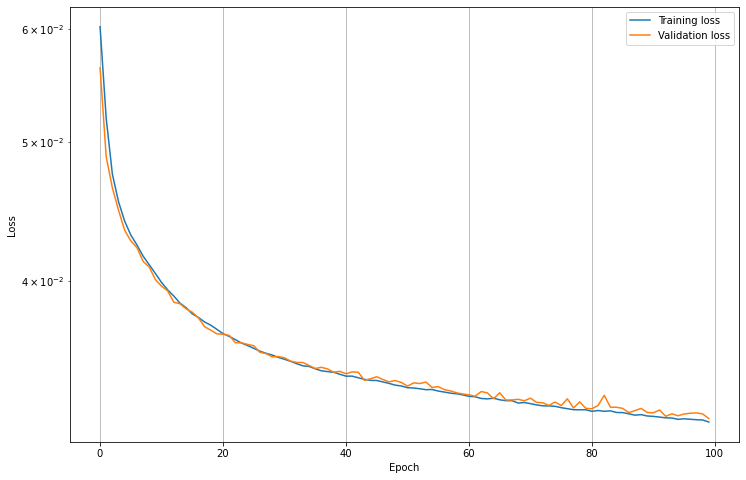

Average traininig  loss in the last 1 epochs: 0.0318
Average validation loss in the last 1 epochs: 0.0320


In [ ]:
nature.plot_losses()

In [ ]:
torch.save(enc.state_dict(), 'basic_ae/enc.pth')
torch.save(dec.state_dict(), 'basic_ae/dec.pth')

## More advanced methods

### Visualize the encoder

#### Slice

In [15]:
def get_encoded_data(enc, dataset):
  '''
  Creates a dataframe with the outputs of the encoder

  Args:
    enc: encoder
    dataset

  Returns:
    pd.DataFrame with columns ['latent var 0', 'latent var 1', ..., 'label'] 
  '''
  old_t = dataset.transform
  dataset.transform = sup_transform

  encoded_samples = []
  enc.eval()
  for sample in tqdm(dataset):
    with torch.no_grad():
      img = sample[0].unsqueeze(0)
      label = sample[1]
      latent_outs = enc(img).squeeze().numpy()

      encoded_sample = {f'latent var {i}': lo for i,lo in enumerate(latent_outs)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)

  # revert dataset to its original transform
  dataset.transform = old_t

  return pd.DataFrame(encoded_samples)


def plot_slice(df, idx1, idx2):
  '''
  Scatters a 2d slice of a dataframe

  Args:
    df: dataframe produced by 'get_encoded_data'
    idx1: index of the column to use as x axis
    idx2 index of the column to use as y axis
  '''
  fig = px.scatter(df, x=f'latent var {idx1}', y=f'latent var {idx2}', color=df.label.astype(str), opacity=0.7)
  fig.show(renderer='colab')

def plot_slice_interactive(df):
  '''
  Allows to interactively choose idx1, idx2 of 'plot_slice'

  Args:
    df: dataframe produced by 'get_encoded_data'
  '''
  n_vars = len(df.columns) - 2
  ipw.interact(plot_slice, df=ipw.fixed(df), idx1=(0, n_vars), idx2=(0, n_vars))

In [ ]:
enc.load_state_dict(torch.load('basic_ae/enc.pth'))

<All keys matched successfully>

In [ ]:
df = get_encoded_data(enc, test_dataset)

In [ ]:
plot_slice_interactive(df)

interactive(children=(IntSlider(value=1, description='idx1', max=3), IntSlider(value=1, description='idx2', ma…

#### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = pca.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice_interactive(reduced_df)

#### t-SNE

In [28]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice_interactive(reduced_df)

interactive(children=(IntSlider(value=0, description='idx1', max=1), IntSlider(value=0, description='idx2', ma…

### Visualize the decoder

#### Interactive data generation

In [ ]:
dec.load_state_dict(torch.load('basic_ae/dec.pth'))

<All keys matched successfully>

In [16]:
def interactive_generation(net, input_range=(-10,10,0.01), add_sigmoid=True, cmap='gist_gray', show_colorbar=False):
  '''
  Allows to generate images from a decoder by interactively setting its inputs

  Args:
    net: decoder
    input_range: (min, max, step): range for choosing the inputs
    add_sigmoid: bool, whether to add add a sigmoid after the net output, default True
    cmap: default 'gist_gray'
    show_colorbar: bool, default False
  '''
  plt.figure()
  def show_img(**kwargs):
    input = torch.tensor(list(kwargs.values())).float()
    with torch.no_grad():
      img = (net(input.unsqueeze(0))).squeeze()
      if add_sigmoid:
        img = torch.sigmoid(img)
    plt.imshow(img.numpy(),cmap=cmap)
    if show_colorbar:
      plt.colorbar()
  d = {}
  for i in range(net.shapes[0]):
    d[f'i{i}'] = input_range
  ipw.interact(show_img, **d)

In [ ]:
interactive_generation(dec, add_sigmoid=False, show_colorbar=True)

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='i0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

### Understanding the bottlenecks

In [ ]:
%%timeit
val_dataset[0]

39.4 µs ± 754 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

start_time = time.time()
nature.train_epoch(verbose=True)
end_time = time.time()

sys.stdout = old_stdout

print(f'running time was {end_time - start_time}')

running time was 15.7969069480896


In [ ]:
lines = buffer.getvalue().split('\n')
times_dict = {}

for line in lines:
  try:
    key, value = line.split(': time ')
    if key not in times_dict:
      times_dict[key] = []
    times_dict[key].append(float(value))
  except:
    print(line)

for k,v in times_dict.items():
  times_dict[k] = np.mean(v)

times_dict

{'preliminary operations': 0.00012731552124023438,
 'Moving data to device': 0.006619077682495117,
 'Forward pass': 0.016081204732259116,
 'Loss conputation': 0.024608134587605794,
 'Optimizer step': 0.004913778305053711,
 'Loss saving': 0.0004229602813720703,
 'Computing loss average': 0.0008192062377929688}

The most expensive computations are in order:
* Computing the loss
* Evaluating the net (with gradent tracking)
* Moving data to the GPU

### Early stopping

In [17]:
class Evolver_es(Evolver):
  '''
  Args:
    patience: int: if after patience peochs the validation loss does not decrease learning stops
    checkpoint: bool or 'net':
      if True, when learning stops the net and the optimizer are checkpointed back to when the validation loss was at its minimum;
      if 'net', only the net is checkpointed back (this means that optimizer checkpoints are not created at all, thus saving time)
      if False, no checkpoints are created

    show_val_loss: bool, default False: if True every time the validation loss reaches a new minimum, this is printed

    *args, **kwargs: arguments of the parent class
    '''
  def __init__(self, patience, checkpoint=False, show_val_loss=False, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = 10

    self.show_val_loss = show_val_loss

    self.checkpoint_net = False
    self.chekpoint_optim = False
    self.checkpoint_epoch = None

    if checkpoint == True:
      self.checkpoint_net = self.checkpoint_net = True
      print('Enabling checkpoint both for net and optimizer')
    elif checkpoint == 'net':
      self.checkpoint_net = True
      print('Enabling checkpoint for net only')
    

  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter = 0
      if self.show_val_loss:
        print(f'epoch {epoch_num}: val loss = {self.best_vl: .7f}')
      if self.checkpoint_net:
        # save epoch number
        self.checkpoint_epoch = epoch_num
        # save net state dicts
        for net_name,net in self.nets.items():
          torch.save(net.state_dict(), f'tmp/{net_name}.pth')
        if self.chekpoint_optim:
          torch.save(self.optimizer.state_dict(), 'tmp/optimizer.pth')
    else:
      self.counter += 1

    if self.counter >= self.patience:
      if self.checkpoint_net:
        print(f'Checkpointing back to epoch {self.checkpoint_epoch}')
        for net_name,net in self.nets.items():
          net.load_state_dict(torch.load(f'tmp/{net_name}.pth'))
        if self.chekpoint_optim:
          self.optimizer.load_state_dict(torch.load('tmp/optimizer.pth'))
        self.train_loss_log = self.train_loss_log[:self.checkpoint_epoch + 1]
        self.val_loss_log = self.val_loss_log[:self.checkpoint_epoch + 1]
      return True
    return False

### Using the BCELoss

<ipython-input-18-d95116ffeb26>:4: RuntimeWarning: divide by zero encountered in log
  bce = -(y*np.log(xs) + (1 - y)*np.log(1 - xs))


Text(0, 0.5, 'dloss/dx')

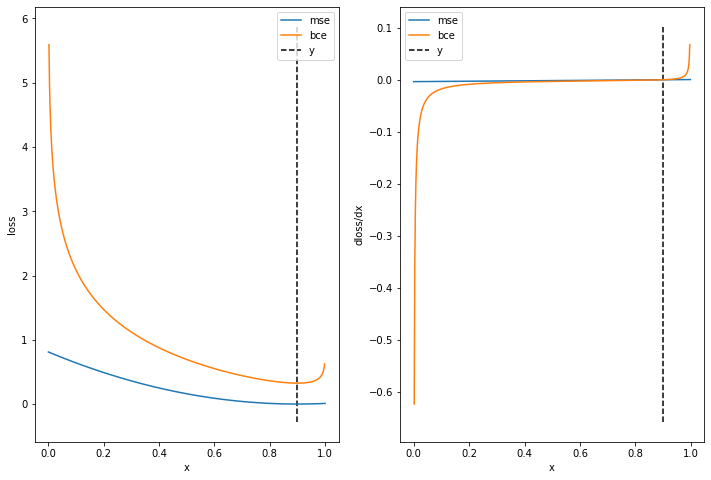

In [18]:
xs = np.linspace(0,1,500)
y = 0.9
mse = (xs - y)**2
bce = -(y*np.log(xs) + (1 - y)*np.log(1 - xs))

fig,ax = plt.subplots(1,2, figsize=(12,8))

ax[0].plot(xs, mse, label='mse')
ax[0].plot(xs, bce, label='bce')
ax[0].vlines([y], *ax[0].get_ylim(), color='black', linestyle='dashed', label='y')
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('loss')

# ax[1].set_xlim(0.4, 0.6)

ax[1].plot(xs[:-1], mse[1:] - mse[:-1], label='mse')
ax[1].plot(xs[:-1], bce[1:] - bce[:-1], label='bce')

# ax[1].plot(xs[:-1], (bce[1:] - bce[:-1])/(mse[1:] - mse[:-1]), label='ratio')

ax[1].vlines([y], *ax[1].get_ylim(), color='black', linestyle='dashed', label='y')
ax[1].legend()
ax[1].set_xlabel('x')
ax[1].set_ylabel('dloss/dx')


The BCE loss promotes sharper images

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4}

decoder_params = {'Ni': 4, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)

nets = OrderedDict({'enc': enc, 'dec': dec})

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-2, weight_decay=1e-5)

evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

evolver_additional_params = {'patience': 2, 'checkpoint':False, 'show_val_loss': True}

# del nature
nature = Evolver_es(**evolver_params, **evolver_additional_params)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Automatically setting o_paddings = [0, 1, 1]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]


In [ ]:
torch.cuda.memory_allocated(0)

733184

In [ ]:
# nature.evolve(100,verbose=True,progress_dir='sigmoid',save_idx='random')
nature.evolve(100)

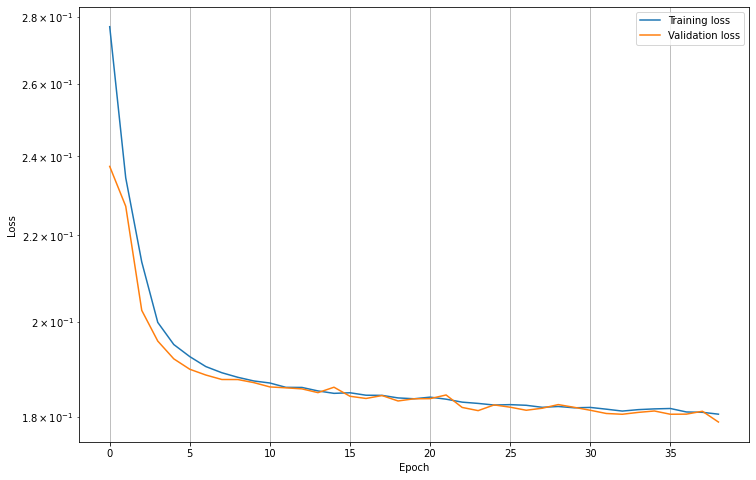

Average traininig  loss in the last 1 epochs: 0.1806
Average validation loss in the last 1 epochs: 0.1791


In [ ]:
nature.plot_losses()

In [ ]:
idx = 34

img, label = val_dataset[idx]

with torch.no_grad():
  img = enc(img.unsqueeze(0))
  print(img)
  img = dec(img)

loss = nn.functional.binary_cross_entropy_with_logits(img,label.unsqueeze(0))


fig,ax = plt.subplots(1,2)

ax[0].imshow(label.squeeze().numpy())
ax[1].imshow(torch.sigmoid(img).squeeze().numpy())

print(f'{loss = }')

In [ ]:
enc.load_state_dict(torch.load('tmp/enc.pth'))
dec.load_state_dict(torch.load('tmp/dec.pth'))

### Pruning

In [ ]:
enc = Encoder(**encoder_params)
enc.load_state_dict(torch.load('tmp/enc.pth'))
dec = Decoder(**decoder_params)
dec.load_state_dict(torch.load('tmp/dec.pth'))
dec_unpruned = Decoder(**decoder_params)
dec_unpruned.load_state_dict(torch.load('tmp/dec.pth'))

nature_unpruned = Evolver(nets=OrderedDict({'enc': enc, 'dec': dec_unpruned}),loss_function=nn.BCEWithLogitsLoss(), val_dataset=val_dataset)
nature = Evolver(nets=OrderedDict({'enc': enc, 'dec': dec}),loss_function=nn.BCEWithLogitsLoss(), val_dataset=val_dataset, val_batch_size=512)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]


In [ ]:
parameters_to_prune_lin = (
    (dec.lin_layers.lin1, 'weight'),
    (dec.lin_layers.lin2, 'weight'),
    (dec.lin_layers.lin3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_lin,
    pruning_method=prune.L1Unstructured,
    amount=0.8
)

parameters_to_prune_conv = (
    (dec.conv_layers.conv1, 'weight'),
    (dec.conv_layers.conv2, 'weight'),
    (dec.conv_layers.conv3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune_conv,
    pruning_method=prune.L1Unstructured,
    amount=0.3
)


In [ ]:
for t in parameters_to_prune_lin:
  prune.remove(*t)
for t in parameters_to_prune_conv:
  prune.remove(*t)

In [ ]:
enc.to(device)
dec.to(device)
dec_unpruned.to(device)
_ = None

In [ ]:
enc.cpu()
dec.cpu()
dec_unpruned.cpu()
_ = None

In [ ]:
nature.test(test_dataset)

0.17965147

In [ ]:
nature_unpruned.test(test_dataset)

0.17923535

Pruning simplifies the net without affecting too much the performance

In [ ]:
interactive_generation(dec)

In [ ]:
interactive_generation(dec_unpruned)

#### Pruning during training

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4}

decoder_params = {'Ni': 4, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder(**encoder_params)
dec = Decoder(**decoder_params)

nets = OrderedDict({'enc': enc, 'dec': dec})

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-2, weight_decay=1e-5)

evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 64}

evolver_additional_params = {'patience': 10, 'checkpoint':True}

del nature
nature = Evolver_es(**evolver_params, **evolver_additional_params)

In [ ]:
prune_every = 5
enc_lin_amount = 0.1
enc_conv_amount = 0.05
dec_lin_amount = 0.1
dec_conv_amount = 0.05

parameters_to_prune_el = [(child, 'weight') for child in enc.lin_layers.children() if isinstance(child, nn.Linear)]
parameters_to_prune_ec = [(child, 'weight') for child in enc.conv_layers.children() if isinstance(child, nn.Conv2d)]
parameters_to_prune_dl = [(child, 'weight') for child in dec.lin_layers.children() if isinstance(child, nn.Linear)]
parameters_to_prune_dc = [(child, 'weight') for child in dec.conv_layers.children() if isinstance(child, nn.ConvTranspose2d)]

n_epochs_th = 0

while n_epochs_th == len(nature.val_loss_log):
  if n_epochs_th != 0:
    print('Pruning')
    prune.global_unstructured(parameters_to_prune_el, pruning_method=prune.L1Unstructured, amount=enc_lin_amount)
    prune.global_unstructured(parameters_to_prune_ec, pruning_method=prune.L1Unstructured, amount=enc_conv_amount)
    prune.global_unstructured(parameters_to_prune_dl, pruning_method=prune.L1Unstructured, amount=dec_lin_amount)
    prune.global_unstructured(parameters_to_prune_dc, pruning_method=prune.L1Unstructured, amount=dec_conv_amount)

    for t in (parameters_to_prune_el + parameters_to_prune_ec + parameters_to_prune_dl + parameters_to_prune_dc):
      prune.remove(*t)

  nature.evolve(prune_every,verbose=True,progress_dir='pruning1',save_idx='random', add_sigmoid=True)
  n_epochs_th += prune_every

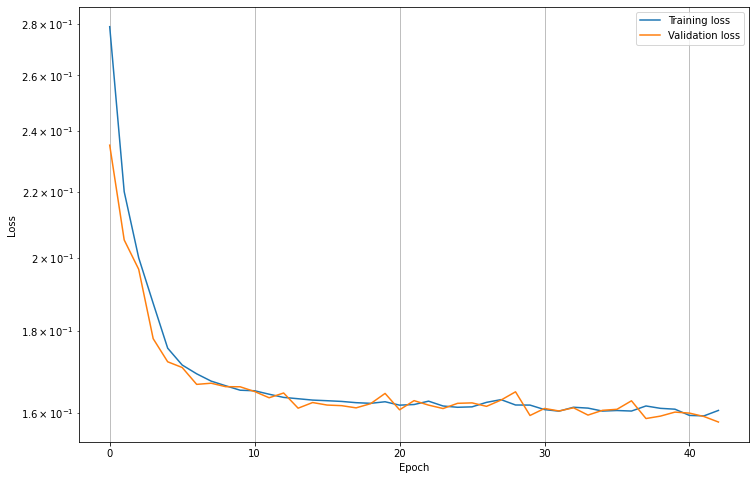

Average traininig  loss in the last 1 epochs: 0.1606
Average validation loss in the last 1 epochs: 0.1579


In [ ]:
nature.plot_losses()

In [19]:
class Evolver_p(Evolver_es):
  '''
  Evolver with pruning during training

  Args:
    prune_every: int: number of epochs every which to prune the nets
    parameters_to_prune: None (recommended) or list of groups of parameters.
      If None it is automatically computed dividing the parameters into four groups: enc lin, enc conv, dec lin, dec conv
    amounts: list with lenght the number of groups: amounts for prune.L1Unstructured

  *args, **kwargs: arguments of the parent class
  '''
  def __init__(self,*args, prune_every=5, parameters_to_prune = None, amounts = None, **kwargs):
    super().__init__(*args, **kwargs)

    self.prune_every = prune_every
    self.parameters_to_prune = parameters_to_prune
    self.amounts = amounts
    
    if self.amounts is not None and self.prune_every > 0 and self.parameters_to_prune is None:
      self.parameters_to_prune = [
                       [(child, 'weight') for child in list(self.nets.values())[0].lin_layers.children() if isinstance(child, nn.Linear)],
                       [(child, 'weight') for child in list(self.nets.values())[0].conv_layers.children() if isinstance(child, nn.Conv2d)],
                       [(child, 'weight') for child in list(self.nets.values())[1].lin_layers.children() if isinstance(child, nn.Linear)],
                       [(child, 'weight') for child in list(self.nets.values())[1].conv_layers.children() if isinstance(child, nn.ConvTranspose2d)]
      ]

    
  def stop_learning(self, num_epoch):
    if self.prune_every*num_epoch > 0 and num_epoch % self.prune_every == 0:
      # print('Pruning')

      for i,ptp in enumerate(self.parameters_to_prune):
        prune.global_unstructured(ptp, pruning_method=prune.L1Unstructured, amount = self.amounts[i])
        for t in ptp:
          prune.remove(*t)

    return super().stop_learning(num_epoch)

### Dropout

In [20]:
class Encoder_d(Encoder):
  '''
  Adds a dropout layer before every hidden linear layer with dropout probability given by 'dropout_probabilities'
  '''
  def __init__(self,*args, dropout_probabilities=None, **kwargs):
    super().__init__(*args,**kwargs)

    if dropout_probabilities is not None:
      self.d_od = OrderedDict()
      i = 0
      for k,l in self.lin_od.items():
        if not k.startswith('lin_act') and i < len(dropout_probabilities):
          self.d_od.update({f'dropout{i+1}': nn.Dropout(dropout_probabilities[i])})
          i += 1
        self.d_od.update({k: l})

      self.lin_layers = nn.Sequential(self.d_od)

class Decoder_d(Decoder):
  '''
  Adds a dropout layer after every hidden linear layer with dropout probability given by 'dropout_probabilities'
  '''
  def __init__(self,*args, dropout_probabilities=None, **kwargs):
    super().__init__(*args,**kwargs)

    if dropout_probabilities is not None:
      self.d_od = OrderedDict()
      i = 0
      for k,l in self.lin_od.items():
        self.d_od.update({k: l})
        if not k.startswith('lin_act') and i < len(dropout_probabilities):
          self.d_od.update({f'dropout{i+1}': nn.Dropout(dropout_probabilities[i])})
          i += 1

      self.lin_layers = nn.Sequential(self.d_od)

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4, 'dropout_probabilities': [0.5,0.5]}

decoder_params = {'Ni': 4, 'Nhs': [16,128], 'dropout_probabilities': [0., 0., 0.],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder_d(**encoder_params)
dec = Decoder_d(**decoder_params)

nets = OrderedDict({'enc_d': enc, 'dec_d': dec})

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-2, weight_decay=0)


evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 128, 'val_batch_size': 512}

evolver_additional_params = {'patience': 10, 'checkpoint':'net'}

# del nature
nature = Evolver_es(**evolver_params, **evolver_additional_params)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]
Enabling checkpoint for net only


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(0)

In [ ]:
enc.cpu()
dec.cpu()
_=None

In [ ]:
nature.evolve(100,verbose=True,progress_dir='dropout3',save_idx='random', add_sigmoid=True)

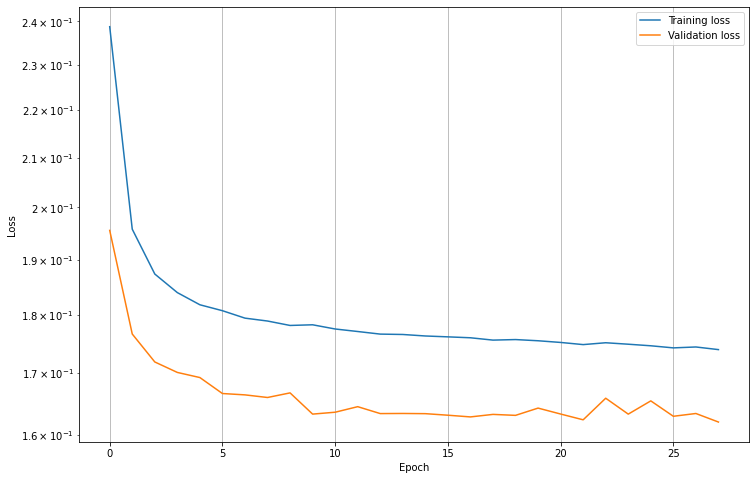

Average traininig  loss in the last 1 epochs: 0.1740
Average validation loss in the last 1 epochs: 0.1621


In [ ]:
nature.plot_losses()

In [ ]:
interactive_generation(dec,add_sigmoid=True, show_colorbar=True, input_range=(-100,100,0.1))

In [ ]:
dec

#### Dropout + pruning

In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4, 'dropout_probabilities': [0.5,0.5]}

decoder_params = {'Ni': 4, 'Nhs': [16,128], 'dropout_probabilities': [0., 0., 0.],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder_d(**encoder_params)
dec = Decoder_d(**decoder_params)

nets = OrderedDict({'enc_d': enc, 'dec_d': dec})

parameters_to_prune = [
                       [(child, 'weight') for child in enc.lin_layers.children() if isinstance(child, nn.Linear)],
                       [(child, 'weight') for child in enc.conv_layers.children() if isinstance(child, nn.Conv2d)],
                       [(child, 'weight') for child in dec.lin_layers.children() if isinstance(child, nn.Linear)],
                       [(child, 'weight') for child in dec.conv_layers.children() if isinstance(child, nn.ConvTranspose2d)]
]

for ptp in parameters_to_prune:
  print(len(ptp))

amounts = [0.1, 0.05, 0.1, 0.05]

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-2, weight_decay=0)


evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 128, 'val_batch_size': 512}

evolver_additional_params = {'patience': 10, 'checkpoint':'net', 'prune_every': 5, 'parameters_to_prune': parameters_to_prune, 'amounts': amounts}

# del nature
nature = Evolver_p(**evolver_params, **evolver_additional_params)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]
2
3
3
3
Enabling checkpoint for net only


In [ ]:
nature.evolve(100,verbose=True,progress_dir='iterative',save_idx='random', add_sigmoid=True)

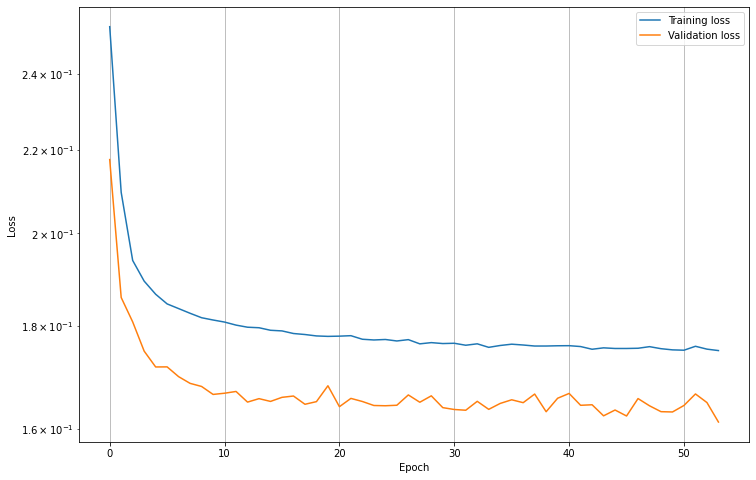

Average traininig  loss in the last 1 epochs: 0.1750
Average validation loss in the last 1 epochs: 0.1613


In [ ]:
nature.plot_losses()

### Iterative autoencoding

In [ ]:
enc.load_state_dict(torch.load('tmp/enc_pruning.pth'))
dec.load_state_dict(torch.load('tmp/dec_pruning.pth'))

iteration 1: loss = tensor(0.1765)
iteration 2: loss = tensor(0.2046)
iteration 3: loss = tensor(0.2151)


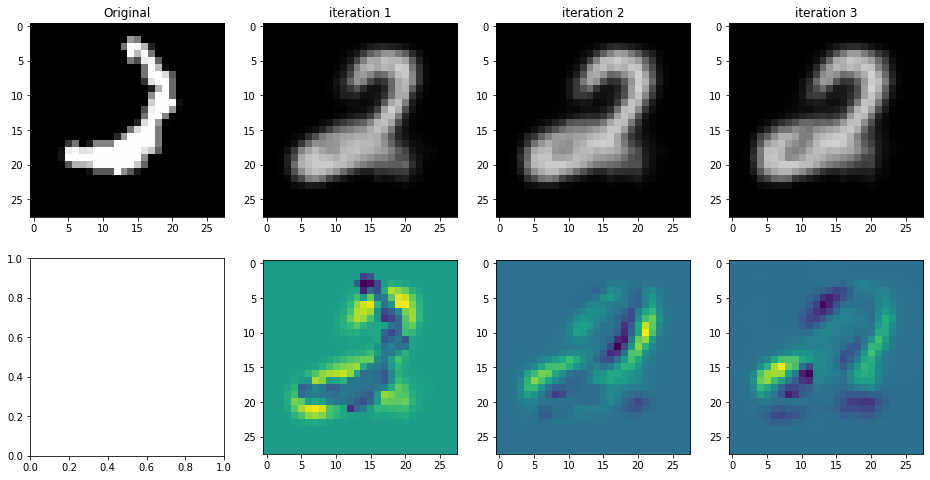

In [ ]:
enc.cpu()
dec.cpu()

idx = 4726
iterations = 3

fig, ax = plt.subplots(2, iterations + 1, figsize=(4*(iterations+1),8))

img = val_dataset[idx][0].unsqueeze(0)

ax[0,0].imshow(torch.clone(img).squeeze().cpu().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[0,0].set_title('Original')

for i in range(iterations):
  with torch.no_grad():
    new_img = torch.sigmoid(dec(enc(img)))
    loss = nn.functional.binary_cross_entropy(new_img, img)
    ax[1,i+1].imshow((new_img - img).squeeze().cpu().numpy())
    img = new_img

    ax[0,i+1].imshow(torch.clone(img).squeeze().cpu().numpy(), cmap='gist_gray', vmin=0, vmax=1)
    ax[0,i+1].set_title(f'iteration {i+1}')

    print(f'iteration {i+1}: loss = {loss}')


#### Iterative autoencoding during training

In [21]:
class Evolver_i(Evolver_es):
  '''
  The loss is computed as
  sum_{i=1}^{'iterations'} 'decay_rate'^{i - 1}*loss(((autoencoder)^i)(original image), original image)
  At every iteration the gradient is allowed to propagate only once through the autoencoder

  Args:
    iterations: int, default 1
    decay_rate: float, default 1.0

  *args, **kwargs: arguments of the parent class
  '''
  def __init__(self, *args, iterations=1, decay_rate=1, **kwargs):
    super().__init__(*args, **kwargs)
    self.iterations = iterations
    self.decay_rate = decay_rate

    self.normalization_factor = np.sum([decay_rate**i for i in range(iterations)])

  def train_epoch(self,verbose=False):
    if verbose:
      time1 = time.time()
    train_loss= []
    # set nets in train mode
    for net in self.nets.values():
      net.train()
    if verbose:
      time2 = time.time()
      print(f'preliminary operations: time {time2 - time1}')
      time1 = time2
    for sample_batched in self.train_dataloader:
      # Move data to device
      out = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      if verbose:
        time2 = time.time()
        print(f'Moving data to device: time {time2 - time1}')
        time1 = time2
      
      partial_losses = []
      for i in range(self.iterations):
        # set previous gradients to 0
        self.optimizer.zero_grad()  
        # Forward pass
        for net in self.nets.values():
          out = net(out)
        if verbose:
          time2 = time.time()
          print(f'Forward pass iteration {i+1}: time {time2 - time1}')
          time1 = time2
        # Compute loss
        partial_losses.append(self.loss_function(out,label_batch)*self.decay_rate**i)
        # shorten the graph:
        out = out.detach()
        if verbose:
          time2 = time.time()
          print(f'Loss conputation: time {time2 - time1}')
          time1 = time2
        
      loss = np.sum(partial_losses)/self.normalization_factor
      # Backpropagation
      loss.backward()
      if verbose:
        time2 = time.time()
        print(f'Backpropagation: time {time2 - time1}')
        time1 = time2
      
      # Update the weights
      self.optimizer.step()
      if verbose:
        time2 = time.time()
        print(f'Optimizer step: time {time2 - time1}')
        time1 = time2

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch*label_batch.size()[0])
      if verbose:
        time2 = time.time()
        print(f'Loss saving: time {time2 - time1}')
        time1 = time2

    # Save average train loss
    train_loss = np.sum(train_loss)/len(self.train_dataset)
    if verbose:
        time2 = time.time()
        print(f'Computing loss average: time {time2 - time1}')
        time1 = time2

    # free gpu memory
    del out
    del label_batch
    torch.cuda.empty_cache()

    return train_loss

  def val_epoch(self,dl):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    n_data = 0
    # set nets in train mode
    for net in self.nets.values():
      net.eval()
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in dl:
        # Move data to device
        out = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        partial_losses = []
        for i in range(self.iterations):
          # Forward pass
          for net in self.nets.values():
            out = net(out)
          # Compute loss
          partial_losses.append(self.loss_function(out,label_batch)*self.decay_rate**i)
        
        loss = np.sum(partial_losses)/self.normalization_factor
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch*label_batch.size()[0])
        n_data += label_batch.size()[0]
        
      # Save average validation loss
      val_loss = np.sum(val_loss)/n_data

      # free gpu memory
      del out
      del label_batch
      torch.cuda.empty_cache()

      return val_loss


In [ ]:
encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4, 'dropout_probabilities': [0.5,0.5]}

decoder_params = {'Ni': 4, 'Nhs': [16,128], 'dropout_probabilities': [0., 0., 0.],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1],
                  'o_act': nn.Identity()}

enc = Encoder_d(**encoder_params)
dec = Decoder_d(**decoder_params)

nets = OrderedDict({'enc_d': enc, 'dec_d': dec})

optimizer = optim.Adam([
                        {'params': enc.parameters()},
                        {'params': dec.parameters()}
                       ], lr=1e-2, weight_decay=0)


evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': torch.nn.BCEWithLogitsLoss(),
                  'train_dataset': train_dataset, 'val_dataset': val_dataset, 'train_batch_size': 256, 'val_batch_size': 512}

evolver_additional_params = {'patience': 10, 'checkpoint':'net', 'iterations': 2, 'decay_rate': 0.5}

# del nature
nature = Evolver_i(**evolver_params, **evolver_additional_params)

Encoder initialized
Shape flow:  [(1, 28, 28), (8, 14, 14), (16, 7, 7), (32, 3, 3), 288, 128, 16, 4]
Decoder initialized
Shape flow:  [4, 16, 128, 288, (32, 3, 3), (16, 7, 7), (8, 14, 14), (1, 28, 28)]
Enabling checkpoint for net only


In [ ]:
nature.evolve(100,verbose=True,progress_dir='iterative2',save_idx='random', add_sigmoid=True)

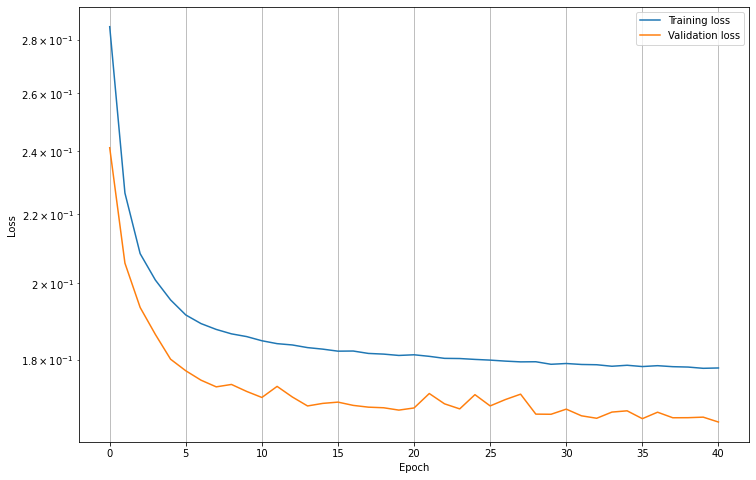

Average traininig  loss in the last 1 epochs: 0.1779
Average validation loss in the last 1 epochs: 0.1651


In [ ]:
nature.plot_losses()

In [ ]:
interactive_generation(dec,add_sigmoid=True, show_colorbar=True, input_range=(-100,100,0.1))

In the end iterative autoencoding is a nice idea, but the high training cost is not compensated by a significant improvement in the results

## KFold

In [22]:
class KFoldCrossValidator(object):
  '''
  Performs a k fold cross validation on a specific set of hyperparameters

  Args:
    k: int, number of folds
    n_runs: int or None: if n_runs < k, only the first n_runs will be performed.
            This is a quick workaround to speed up the hyperparameter optimization process
    shuffle: bool: if true data is shuffled before the splitting in k folds
    all_train_dataset: Dataset with train and validation data that will be split in folds

    net_type: list of user defined class
    net_params: list of dictionaries or list of lists of the arguments for net_type.__init__

    optimizer_type: e.g. optim.Adam
    optimizer_params: dictionary or list of the arguments of the optimizer (except net.parameters())

    loss_function
    train_batch_size: int, default 256

    evolver_type: e.g. Evolver or Evolver_es
    evolver_additional_params: dictionary with additional parameters for the evolver,
      e.g. if evolver_type = Evolver_es, the additional parameter 'patience' must be provided
  '''

  def __init__(self, k, n_runs=None, shuffle=False, all_train_dataset=None, net_types=None, net_params=None,
               optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size=256, val_batch_size=512, evolver_type=None, evolver_additional_params=None):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_dataset = all_train_dataset

    self.net_types = net_types
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.train_batch_size = train_batch_size
    self.val_batch_size = val_batch_size

    self.loss_function = loss_function

    self.evolver_type = evolver_type
    self.evolver_additional_params = evolver_additional_params
    if self.evolver_additional_params is None:
      self.evolver_additional_params = {}

    self.evolvers = []

    # set up the object with k (or n_runs) evolvers
    i = 0
    for train_idx, val_idx in self.splitter.split(list(range(len(self.all_train_dataset)))):
      # datasets
      train_dataset = Subset(self.all_train_dataset, train_idx)
      val_dataset = Subset(self.all_train_dataset, val_idx)

      # nets
      nets = OrderedDict({})
      params_to_optimize = []
      for j,net_type in enumerate(self.net_types):
        n_p = self.net_params[j]
        if type(n_p) == dict:
          net = net_type(**n_p)
        else:
          net = net_type(*n_p)
        nets.update({f'net{j+1}': net})
        params_to_optimize.append({'params': net.parameters()})

      # optimizer
      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(params_to_optimize,**self.optimizer_params)
      else:
        optimizer = self.optimizer_type(params_to_optimize,*self.optimizer_params)

      evolver_params = {'nets': nets, 'optimizer': optimizer, 'loss_function': self.loss_function,
                        'train_dataset': train_dataset, 'val_dataset': val_dataset,
                        'train_batch_size': self.train_batch_size, 'val_batch_size': self.val_batch_size}

      # evolver
      evolver = self.evolver_type(**evolver_params, **self.evolver_additional_params)

      self.evolvers.append(evolver)

      i += 1
      if n_runs is not None and i >= n_runs:
        break

  def to(self, device):
    for evolver in self.evolvers:
      evolver.to(device)
  
  def cpu(self):
    for evolver in self.evolvers:
      evolver.cpu()

  def train(self):
    for evolver in self.evolvers:
      evolver.train()
  
  def eval(self):
    for evolver in self.evolvers:
      evolver.eval()


  def run(self,num_epochs,loss_sample_size=1, prune_thr=None, **evolve_kwargs):
    '''
    Args:
      num_epochs: maximum number of epochs for each fold
      loss_sample_size: number of epochs for computing the average train and val losses, default 10
      prune_thr: folat or None: if one of the final validation losses is > prune thr, the run is interrupted raising a ValueError
    '''
    for k,evolver in enumerate(self.evolvers):
      evolver.evolve(num_epochs, **evolve_kwargs)
      if prune_thr is not None and k < len(self.evolvers)/2 and evolver.val_loss_log[-1] > prune_thr:
        print(f'Trial pruned: val loss was {evolver.val_loss_log[-1]}')
        raise ValueError


      # print avg train and val loss
      print(np.mean(evolver.train_loss_log[-loss_sample_size:]), np.mean(evolver.val_loss_log[-loss_sample_size:]))

    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.evolvers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.evolvers])
    
    return avg_train_loss, avg_val_loss
    

  def view(self,idx):
    '''
    Plot losses and net output
    Args:
      idx: int in [0, n_runs) or 'best', index of the evolver to view
    '''
    if idx == 'best':
      idx = np.argmin([e.best_vl for e in self.evolvers])
      print(f'Best evolver is number {idx} with minimum validation loss {self.evolvers[idx].best_vl}')

    self.evolvers[idx].plot_losses()

In [ ]:
# testing
k = 5
n_runs = 3

encoder_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
                  'Nhs': [128, 16], 'No': 4}

decoder_params = {'Ni': 4, 'Nhs': [16,128],
                  'channels': [32,16,8], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [0,1,1]}

net_types = [Encoder, Decoder]
net_params = [encoder_params, decoder_params]

train_batch_size = 256
val_batch_size = 256

optimizer_type = optim.Adam
optimizer_params={'lr': 0.01}

loss_function = nn.BCEWithLogitsLoss()

evolver_type = Evolver_es
evolver_additional_params = {'patience': 5, 'checkpoint':'net'}

kf = KFoldCrossValidator(k,n_runs,shuffle=True,all_train_dataset=all_train_dataset,train_batch_size=256,val_batch_size=512,
                         net_types=net_types, net_params=net_params, loss_function=loss_function,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params,
                         evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

In [ ]:
kf.run(100,loss_sample_size=1)

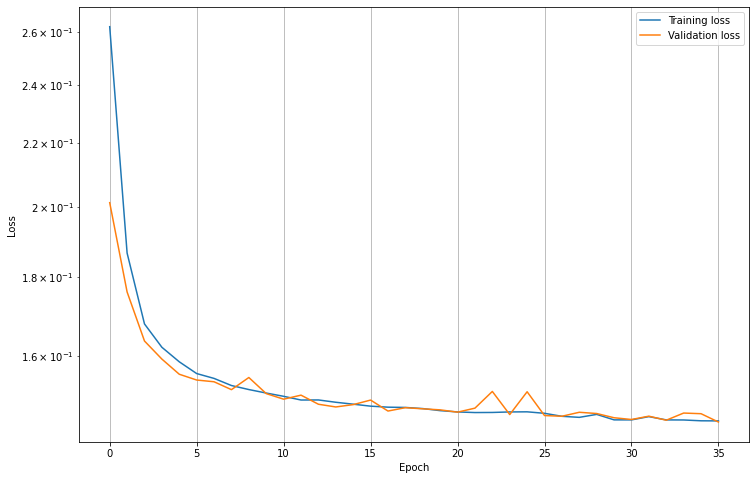

Average traininig  loss in the last 1 epochs: 0.1452
Average validation loss in the last 1 epochs: 0.1449


In [ ]:
kf.view(0)

## Hyperparameters search with optuna

In [ ]:
import optuna
global df
df = None

In [ ]:
k = 5
n_runs = 2
prune_thr = 0.2

name = 'optuna_symmetrical_search'

if os.path.exists(f'{name}.csv'):
  df = pd.read_csv(f'{name}.csv')
  print('Loading existing study')


optimizer_type = optim.Adam

loss_function = nn.BCEWithLogitsLoss()

net_types = [Encoder_d, Decoder] # dropout only in the encoder

evolver_type = Evolver_p

# add a time penalty as regularizer
time_penalty = 1e-5

latent_space_penalty = 1e-2

def objective(trial):

  global df

  # sample hypermarameters
  
  # convolutional layers part
  n_c_layers = trial.suggest_int('ncl', 2, 4)
  
  channels = []
  kernel_sizes = []
  strides = []
  paddings = []

  for j in range(n_c_layers):
    channels.append(trial.suggest_int(f'ch{j+1}', 4, 8*2**j))
    kernel_sizes.append(trial.suggest_int(f'ks{j+1}', 2, 6))
    strides.append(trial.suggest_int(f'stride{j+1}', 1, 4))
    paddings.append(trial.suggest_int(f'padding{j+1}', 0, kernel_sizes[-1]//2))


  # linear layers part
  n_l_layers = trial.suggest_int('nll', 1, 3)

  Nhs = []
  ps = []

  for j in range(n_l_layers):
    Nhs.append(trial.suggest_int(f'Nh{j+1}', 8, 256/2**j, log=True))
    ps.append(trial.suggest_float(f'p{j+1}', 0, 0.7))

  N_latent = trial.suggest_int('N_latent',1,16)

  # net params
  encoder_params = {'channels': channels.copy(), 'kernel_sizes': kernel_sizes.copy(), 'strides': strides.copy(), 'paddings': paddings.copy(),
                    'Nhs': Nhs.copy(), 'No': N_latent, 'dropout_probabilities': ps}
  print(encoder_params)

  channels.reverse()
  kernel_sizes.reverse()
  strides.reverse()
  paddings.reverse()
  Nhs.reverse()

  decoder_params = {'Ni': N_latent, 'Nhs': Nhs,
                  'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings}
  print(decoder_params)

  net_params = [encoder_params, decoder_params]

  
  # optimizer part
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-7,1e-1, log=True)
  
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}

  # train_batch_size
  train_batch_size = trial.suggest_int('train_batch_size', 64, 512, log=True)

  # patience
  patience = trial.suggest_int('patience',4,16)

  # pruning parameters
  amounts = []
  for j in range(4):
    amounts.append(trial.suggest_float(f'pruning_amount{j+1}', 0, 0.5))

  prune_every = trial.suggest_int('prune_every', 0, 10)

  evolver_additional_params = {'patience': patience, 'show_val_loss': True,
                               'prune_every': prune_every, 'amounts': amounts}

  print(evolver_additional_params)

  start_time = time.time()
  try:
    kf = KFoldCrossValidator(k,n_runs,shuffle=True,all_train_dataset=all_train_dataset,train_batch_size=train_batch_size,val_batch_size=512,
                            net_types=net_types, net_params=net_params, loss_function=loss_function,
                            optimizer_type=optimizer_type, optimizer_params=optimizer_params,
                            evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

    avg_tr_loss, avg_val_loss = kf.run(50, prune_thr=prune_thr)
  except KeyboardInterrupt:
    raise KeyboardInterrupt
  except (TypeError, ValueError):
    raise optuna.TrialPruned() # to stop trials that produce invalid nets

  
  train_time = (time.time() - start_time)/(60*n_runs) # avg train time in minutes

  print(f'{avg_tr_loss = }, {avg_val_loss = }, {train_time = } min')

  # dictionary with all the hyperparameters and performance of the net
  hyper_dict = dict(**encoder_params, **optimizer_params, **evolver_additional_params,
                    **{'avg_tr_loss': avg_tr_loss, 'avg_val_loss': avg_val_loss, 'train_time': train_time})

  if df is None:
    df = pd.DataFrame([], columns=list(hyper_dict.keys()))

  df.loc[len(df)] = hyper_dict

  df.to_csv(f'{name}.csv', index=False)

  return np.mean([e.best_vl for e in kf.evolvers]) + time_penalty*train_time + N_latent*latent_space_penalty


study = optuna.create_study(study_name=name, storage=f'sqlite:///{name}.db', load_if_exists=True)

[I 2021-01-26 19:09:52,990] Using an existing study with name 'optuna_symmetrical_search' instead of creating a new one.


Loading existing study


In [ ]:
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
study.trials_dataframe().to_csv('wtf.csv',index=False)

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(0)

5894656

### Analyze the study

In [ ]:
study.best_params

{'N_latent': 6,
 'Nh1': 57,
 'ch1': 6,
 'ch2': 12,
 'ch3': 17,
 'ks1': 2,
 'ks2': 2,
 'ks3': 3,
 'lr': 0.002892682742579524,
 'ncl': 3,
 'nll': 1,
 'p1': 0.19015101404649162,
 'padding1': 1,
 'padding2': 0,
 'padding3': 1,
 'patience': 13,
 'prune_every': 5,
 'pruning_amount1': 0.3984340115492294,
 'pruning_amount2': 0.10014416305834842,
 'pruning_amount3': 0.2135077871397597,
 'pruning_amount4': 0.0679659281580344,
 'stride1': 1,
 'stride2': 1,
 'stride3': 3,
 'train_batch_size': 383,
 'weight_decay': 6.505651220946865e-07}

In [ ]:
fig = optuna.visualization.plot_contour(study,params=['ks2', 'pruning_amount1'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show(renderer='colab')

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show(renderer='colab')

### Best net

In [ ]:
k = 5
n_runs = 5

e_kwargs = {'progress_dir': 'best_net','save_idx': 'random', 'verbose': True}

channels = [6,12,17]
kernel_sizes = [2,2,3]
strides = [1,1,3]
paddings = [1,0,1]

Nhs = [57]
N_latent = 6

ps = [0.1905]

train_batch_size = 383

optimizer_params = {'lr': 0.00289, 'weight_decay': 6.506e-7}
 
evolver_additional_params = {'patience': 13, 'checkpoint': 'net',
                             'prune_every': 5, 'amounts': [0.398, 0.1, 0.214, 0.068]}

optimizer_type = optim.Adam

loss_function = nn.BCEWithLogitsLoss()

net_types = [Encoder_d, Decoder] # dropout only in the encoder

evolver_type = Evolver_p

encoder_params = {'channels': channels.copy(), 'kernel_sizes': kernel_sizes.copy(), 'strides': strides.copy(), 'paddings': paddings.copy(),
                  'Nhs': Nhs.copy(), 'No': N_latent, 'dropout_probabilities': ps}
print(encoder_params)

channels.reverse()
kernel_sizes.reverse()
strides.reverse()
paddings.reverse()
Nhs.reverse()

decoder_params = {'Ni': N_latent, 'Nhs': Nhs,
                  'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings}
print(decoder_params)

net_params = [encoder_params, decoder_params]

In [ ]:
kf = KFoldCrossValidator(k,n_runs,shuffle=True,all_train_dataset=all_train_dataset,train_batch_size=train_batch_size,val_batch_size=512,
                         net_types=net_types, net_params=net_params, loss_function=loss_function,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params,
                         evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

In [ ]:
avg_tr_loss, avg_val_loss = kf.run(100,**e_kwargs)

In [ ]:
kf.view('best')

train and val loss for the 5 folds:

[
          [0.1282, 0.1259],
          [0.1267, 0.1253],
          [0.1284, 0.1271],
          [0.1296, 0.1267],
          [0.1339, 0.1317]
]

#### Test and visualization

In [ ]:
enc = Encoder_d(**encoder_params)
enc.load_state_dict(torch.load('best_ae/enc.pth'))
dec = Decoder(**decoder_params)
dec.load_state_dict(torch.load('best_ae/dec.pth'))

nature = Evolver(nets=[enc,dec],loss_function=loss_function)

In [ ]:
enc.to(device)
dec.to(device)
test_loss = nature.test(test_dataset)
enc.cpu()
dec.cpu()
print(test_loss)

0.12458056765794755


In [ ]:
interactive_generation(dec, show_colorbar=True, input_range=(-4,4,0.01))

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='i0', max=4.0, min=-4.0, step=0.01), FloatSlider(valu…

In [ ]:
df = get_encoded_data(enc,test_dataset)

In [ ]:
plot_slice_interactive(df)

interactive(children=(IntSlider(value=2, description='idx1', max=5), IntSlider(value=2, description='idx2', ma…

In [ ]:
pca = PCA(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = pca.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice_interactive(reduced_df)

interactive(children=(IntSlider(value=0, description='idx1', max=1), IntSlider(value=0, description='idx2', ma…

In [30]:
tsne = TSNE(n_components=3)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

# plot_slice_interactive(reduced_df)

In [31]:
fig = px.scatter_3d(reduced_df, x='latent var 0', y='latent var 1', z='latent var 2', color=reduced_df.label.astype(str))
fig.show(renderer='colab')

## Denoising autoencoder

### Defining different types of noise

In [32]:
class UniformRandomNoise():
  '''
  Sums to the every pixel of input image a noise sampled from the uniform distribution in [-'amount'/2, 'amount'/2].
  The resulting image is then clipped into [0,1]

  Args:
    amount: float
  '''
  def __init__(self, amount):
    self.amount = amount

  def __call__(self, sample):
    pic, label = sample

    n = torch.rand(pic.size())*self.amount - self.amount/2
    pic = torch.clip(pic + n, 0, 1)
    
    sample = (pic, label)
    return sample

class SaltNPepper():
  '''
  Randomly sets to 0 or 1 'amount' fraction of the pixels of the input image

  Args:
    amount
  '''
  def __init__(self,amount):
    self.amount = amount

  def __call__(self,sample):
    if self.amount == 0:
      return sample
    pic, label = sample

    n = 2*torch.rand(pic.size()) - 1
    n[n**2 > self.amount**2] = 0 

    pic = torch.clip(pic + n*100, 0,1)

    sample = (pic, label)
    return sample


class RandomHole():
  '''
  Randomly superimposes to the input image a rectangle of size 'size' blacking out the pixels beneath

  Args:
    size: int or 2-ple:
      e.g. size=7 is equivalent to size=(7,7)
      if a 2-ple is provided the first element is the horizontal size and the second the vertical one.
  '''
  def __init__(self,size):
    if type(size) == int:
      self.size = (size,size)
    else:
      self.size = size
    
    self.do_something = True
    if 0 in self.size:
      self.do_something = False

  def __call__(self, sample):
    if not self.do_something:
      return sample

    pic, label = sample

    n = torch.ones_like(pic)
    x = np.random.randint(pic.size()[-2] - self.size[-2])
    y = np.random.randint(pic.size()[-1] - self.size[-1])
    n[...,x:x+self.size[0],y:y+self.size[1]] = 0

    pic = pic*n

    sample = (pic, label)
    return sample

class RandomRotation():
  '''
  Randomly rotates the input image by an angle sampled from the uniform distribution on [min_degrees, max_degrees]

  Args:
    max_degrees: float
    min_degrees: float, optional:
      if not provided min_degrees = -max_degrees
  '''
  def __init__(self, max_degrees, min_degrees=None):
    if min_degrees is None:
      self.rotator = transforms.RandomRotation(max_degrees)
    else:
      self.rotator = transforms.RandomRotation((min_degrees, max_degrees))

  def __call__(self, sample):
    pic, label = sample
    pic = self.rotator(pic)
    sample = pic, label

    return sample

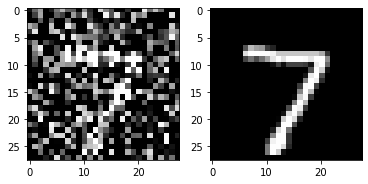

In [ ]:
test_dataset.transform = transforms.Compose([
                                             ToTensor(),
                                             ReplaceLabel(),
                                             UniformRandomNoise(2)
                                            #  RandomRotation(45),
                                            #  ToTensorBoth(),
                                            #  SaltNPepper(0.1)
])

fig, ax = plt.subplots(1,2)
noisy_img, img = test_dataset[0]
ax[0].imshow(noisy_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[1].imshow(img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)

In [ ]:
%%timeit
test_dataset[0]

125 µs ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Timings:
* No noise addition: 36.2 $\mu$s
* UniformRandomNoise: 83.3 $\mu$s
* SaltNPepper: 169 $\mu$s
* RandomHole: 82.4 $\mu$s
* RandomRotation: 125 $\mu$s

### Best autoencoder vs noise

In [ ]:
test_dataset.transform = transforms.Compose([
                                             ToTensor(),
                                             ReplaceLabel(),
                                            #  SaltNPepper(0.1),
                                             UniformRandomNoise(1),
                                            #  RandomHole((10,26)),
])

In [ ]:
idx = 345

fig, ax = plt.subplots(1,3, figsize=(8,24))
noisy_img, img = test_dataset[idx]
ax[0].imshow(img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[0].set_title('Original image')
ax[1].imshow(noisy_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[1].set_title('Noisy image')

enc.eval()
dec.eval()
with torch.no_grad():
  out_img = dec(enc(noisy_img.unsqueeze(0)))


ax[2].imshow(out_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[2].set_title('Reconstructed image')

In [ ]:
enc.to(device)
dec.to(device)
test_loss = nature.test(test_dataset)
enc.cpu()
dec.cpu()
print(test_loss)

0.30532348594665526


Test loss of the best autoencoder:
* No noise: 0.12458
* SaltNPepper(0.1): 0.24589
* UniformRandomNoise(0.7): 0.31500
* RandomHole((7,7)): 0.14888
* RandomHole((26,4)): 0.15595
* RandomHole((4,26)): 0.16265
* RandomHole((10,26)): 0.31327
* RandomRotation(45): 0.30532

We observe that in the Original dataset some numbers appear already rotated a bit, so the autoencoder learned that. So maybe rotation cannot be considered noise.

### Training against noise

#### Starting from the pretrained autoencoder

In [ ]:
k = 5
n_runs = 1

all_train_dataset.transform = transforms.Compose([
                                                  ToTensor(),
                                                  ReplaceLabel(),
                                                  UniformRandomNoise(2),
                                                  SaltNPepper(0.1),
                                                  # RandomHole((10,26)),
])

e_kwargs = {'progress_dir': 'progress_log/denoising_urn2','save_idx': 'random', 'verbose': True}

channels = [6,12,17]
kernel_sizes = [2,2,3]
strides = [1,1,3]
paddings = [1,0,1]

Nhs = [57]
N_latent = 6

ps = [0.1905]

train_batch_size = 383

optimizer_params = {'lr': 0.00289, 'weight_decay': 6.506e-7}
 
evolver_additional_params = {'patience': 13, 'checkpoint': 'net',
                             'prune_every': 5, 'amounts': [0.398, 0.1, 0.214, 0.068]}

optimizer_type = optim.Adam

loss_function = nn.BCEWithLogitsLoss()

net_types = [Encoder_d, Decoder] # dropout only in the encoder

evolver_type = Evolver_p

encoder_params = {'channels': channels.copy(), 'kernel_sizes': kernel_sizes.copy(), 'strides': strides.copy(), 'paddings': paddings.copy(),
                  'Nhs': Nhs.copy(), 'No': N_latent, 'dropout_probabilities': ps}
print(encoder_params)

channels.reverse()
kernel_sizes.reverse()
strides.reverse()
paddings.reverse()
Nhs.reverse()

decoder_params = {'Ni': N_latent, 'Nhs': Nhs,
                  'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings}
print(decoder_params)

net_params = [encoder_params, decoder_params]

{'channels': [6, 12, 17], 'kernel_sizes': [2, 2, 3], 'strides': [1, 1, 3], 'paddings': [1, 0, 1], 'Nhs': [57], 'No': 6, 'dropout_probabilities': [0.1905]}
{'Ni': 6, 'Nhs': [57], 'channels': [17, 12, 6], 'kernel_sizes': [3, 2, 2], 'strides': [3, 1, 1], 'paddings': [1, 0, 1]}


In [ ]:
kf = KFoldCrossValidator(k,n_runs,shuffle=True,all_train_dataset=all_train_dataset,train_batch_size=train_batch_size,val_batch_size=512,
                         net_types=net_types, net_params=net_params, loss_function=loss_function,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params,
                         evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

for evolver in kf.evolvers:
  evolver.nets['net1'].load_state_dict(torch.load('tmp/best1/enc.pth'))
  evolver.nets['net2'].load_state_dict(torch.load('tmp/best1/dec.pth'))

Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 6]
Automatically setting o_paddings = [0, 0, 0]
Decoder initialized
Shape flow:  [6, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]
Enabling checkpoint for net only


In [ ]:
avg_tr_loss, avg_val_loss = kf.run(100,**e_kwargs)

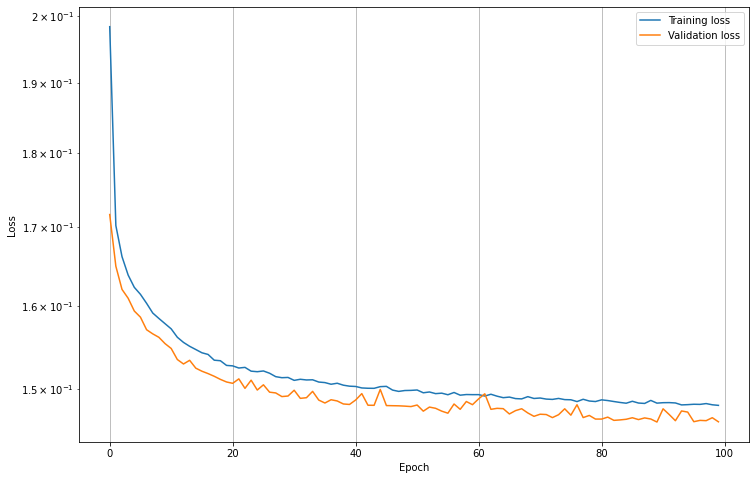

Average traininig  loss in the last 1 epochs: 0.1482
Average validation loss in the last 1 epochs: 0.1463


In [ ]:
kf.view(0)

In [ ]:
nature_d = kf.evolvers[0]

test_dataset.transform = transforms.Compose([
                                             ToTensor(),
                                             ReplaceLabel(),
                                            #  SaltNPepper(0.1),
                                             UniformRandomNoise(2),
                                            #  RandomHole((10,26)),
])

for net in nature_d.nets.values():
  net.to(device)
test_loss = nature_d.test(test_dataset)
for net in nature_d.nets.values():
  net.cpu()

print(test_loss)

0.14048207473754884


After 52 epochs of training against SaltNPepper(0.1) the test losses are:

* No noise: 0.12387
* SaltNPepper(0.1): 0.12490
* UniformRandomNoise(0.7): 0.29201

After 55 epochs of training against UniformRandomNoise(0.7) the test losses are:

* No noise: 0.12325
* SaltNPepper(0.1): 0.25386
* UniformRandomNoise(0.7): 0.12386

After 60 epochs of training against both of the previous:

* No noise: 0.12362
* SaltNPepper(0.1): 0.12476
* UniformRandomNoise(0.7): 124153
* both: 0.12742

After 100 epochs of training against UniformRandomNoise(2) + SaltNPepper(0.1):

* No noise: 0.14078
* SaltNPepper(0.1): 0.14044
* UniformRandomNoise(0.7): 0.14025
* UniformRandomNoise(2): 0.14048

#### Comparison with the best simple autoencoder

In [33]:
enc = Encoder_d(**encoder_params)
enc.load_state_dict(torch.load('tmp/best1/enc.pth'))
dec = Decoder(**decoder_params)
dec.load_state_dict(torch.load('tmp/best1/dec.pth'))

nature = Evolver(nets=[enc,dec],loss_function=loss_function)

enc_d = Encoder_d(**encoder_params)
enc_d.load_state_dict(torch.load('tmp/denoising_urn2-snp0.1/net1.pth'))
dec_d = Decoder(**decoder_params)
dec_d.load_state_dict(torch.load('tmp/denoising_urn2-snp0.1/net2.pth'))

nature_d = Evolver(nets=[enc_d,dec_d],loss_function=loss_function)

Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 6]
Automatically setting output paddings to [0, 0, 0]
Decoder initialized
Shape flow:  [6, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]
Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 6]
Automatically setting output paddings to [0, 0, 0]
Decoder initialized
Shape flow:  [6, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]


In [ ]:
test_dataset.transform = sup_transform

df = get_encoded_data(enc_d,test_dataset)
tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice_interactive(reduced_df)

interactive(children=(IntSlider(value=0, description='idx1', max=1), IntSlider(value=0, description='idx2', ma…

In [ ]:
interactive_generation(dec_d, input_range=(-4,4,0.01), show_colorbar=True)

In [ ]:
test_dataset.transform = transforms.Compose([
                                             ToTensor(),
                                             ReplaceLabel(),
                                            #  SaltNPepper(0.1),
                                             UniformRandomNoise(1),
                                            #  RandomHole((10,26)),
])

Text(0.5, 1.0, 'Rec. image d')

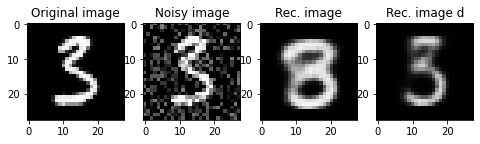

In [ ]:
idx = 890

fig, ax = plt.subplots(1,4, figsize=(8,32))
noisy_img, img = test_dataset[idx]
ax[0].imshow(img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[0].set_title('Original image')
ax[1].imshow(noisy_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[1].set_title('Noisy image')

enc.eval()
dec.eval()
with torch.no_grad():
  out_img = torch.sigmoid(nature(noisy_img.unsqueeze(0)))

ax[2].imshow(out_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[2].set_title('Rec. image')

enc_d.eval()
dec_d.eval()
with torch.no_grad():
  out_img_d = torch.sigmoid(nature_d(noisy_img.unsqueeze(0)))

ax[3].imshow(out_img_d.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[3].set_title('Rec. image d')


#### At this point does the autoencoder hallucinate?

In [ ]:
import noise

class Perlin():
  '''
  Generates Perlin noise

  Args:
    shape: 2-ple, default (28,28): shape of the image to generate
    p: float, default 0.1: probability of generating a perlin noise image instead of simply returning the original image
    saturation: float, default 10: how much to increase the contrast of the image

    pnoise_kwargs: dictionary of arguments to pass to noise.pnoise2: default {'octaves': 8, 'persistence': 0.5, 'lacunarity': 2}
  '''
  def __init__(self, shape=(28,28), p=0.1, saturation=10, pnoise_kwargs={'octaves': 8, 'persistence': 0.5, 'lacunarity': 2}):
    self.shape = shape
    self.p = p
    self.saturation = saturation
    self.pnoise_kwargs = pnoise_kwargs
    self.vpnoise = np.vectorize(self._vpnoise)
    self.x = None
    self.y = None
    self.x,self.y = np.meshgrid(np.arange(self.shape[0])/self.shape[0], np.arange(self.shape[0])/self.shape[0])
    self.x = self.x.flatten()
    self.y = self.y.flatten()

  def _vpnoise(self,x,y):
    return noise.pnoise2(x,y,**self.pnoise_kwargs)

  def create_image(self):
    '''
    Generate a perlin noise image
    '''
    x_t = np.random.uniform(0,1024)
    y_t = np.random.uniform(0,1024)

    img = self.vpnoise(self.x + x_t, self.y + y_t).reshape(self.shape)

    # convert to tensor
    img = torch.tensor(img).float().unsqueeze(0)
    #saturate the image
    img = torch.sigmoid(self.saturation*img)
    return img

  def __call__(self,sample):
    if np.random.uniform(0,1) < self.p:
      sample = (self.create_image(), 10)

    else:
      pic, label = sample
      pic = transforms.ToTensor()(pic)
      sample = (pic, label)

    return sample

In [ ]:
test_dataset.transform = transforms.Compose([
                                            #  Perlin(p=1),
                                             ToTensor(),
                                             RandomHole(26),
                                             UniformRandomNoise(1),
])

Text(0.5, 1.0, 'Rec. image d')

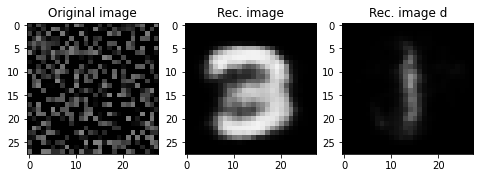

In [ ]:
idx = 0

fig, ax = plt.subplots(1,3, figsize=(8,24))
img, _ = test_dataset[idx]
ax[0].imshow(img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[0].set_title('Original image')

enc.eval()
dec.eval()
with torch.no_grad():
  out_img = torch.sigmoid(nature(img.unsqueeze(0)))

ax[1].imshow(out_img.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[1].set_title('Rec. image')

enc_d.eval()
dec_d.eval()
with torch.no_grad():
  out_img_d = torch.sigmoid(nature_d(img.unsqueeze(0)))

ax[2].imshow(out_img_d.squeeze().numpy(), cmap='gist_gray', vmin=0, vmax=1)
ax[2].set_title('Rec. image d')

## Supervised fine-tuning

In [ ]:
class FCN(nn.Module):
  def __init__(self, Ni, Nhs=None, No=10, activation_function=nn.ReLU, o_act=nn.Identity()):
    '''
    Fully connencted network

    Args:
      Ni: input neurons
      Nhs: list of neurons of the hidden layers
      No: output neurons
      activation_function: default nn.ReLU (beware not nn.ReLU() !!)
      o_act: activation function after the output layer, default nn.Identity()
    '''
    super().__init__()

    self.od = OrderedDict({})
    self.shapes = [Ni]
    if Nhs is not None and len(Nhs) > 0:
      self.shapes += Nhs

    for i,s in enumerate(self.shapes[:-1]):
      self.od.update({f'lin{i+1}': nn.Linear(s, self.shapes[i+1])})
      self.od.update({f'lin_act{i+1}': activation_function()})
    
    self.od.update({'out': nn.Linear(self.shapes[-1], No)})
    self.shapes.append(No)

    self.lin_layers = nn.Sequential(self.od)

    self.o_act = o_act

    print('FCN initialized')
    print('Shape flow: ', self.shapes)

  def forward(self, x):
    x = self.o_act(self.lin_layers(x))
    return x


def evaluate_net(net, test_dataset, use_gpu=True):
  '''
  Computes confusion matrix and accuracy
  Args:
    net
    test_dataset
  
  Returns:
    confusion_matrix: pd.DataFrame
    accuracy = fraction of correctly classified samples
  '''
  test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

  net_outputs = np.array([])
  labels = np.array([])

  net.eval()
  if use_gpu:
    net.to(device)
  with torch.no_grad():
    for batch in test_dataloader:
      if use_gpu:
        out = torch.argmax(net(batch[0].to(device)), dim=1).cpu().numpy()
      else:
        out = torch.argmax(net(batch[0]), dim=1).cpu().numpy()
      # print(out.shape)
      label = batch[1].squeeze().cpu().numpy()

      net_outputs = np.concatenate([net_outputs, out])
      labels = np.concatenate([labels, label])

  if use_gpu:
    net.cpu()

  net_outputs = np.array(net_outputs, dtype=int)
  labels = np.array(labels, dtype=int)

  cm_df = pd.DataFrame(data=confusion_matrix(labels, net_outputs))
  accuracy = np.mean(net_outputs == labels)

  return cm_df, accuracy

In [ ]:
k = 5
n_runs = 1

all_train_dataset.transform = sup_transform

e_kwargs = {'verbose': True}

encoder_params = {'channels': [6,12,17], 'kernel_sizes': [2,2,3], 'strides': [1,1,3], 'paddings': [1,0,1],
                  'Nhs': [57], 'No': 6, 'dropout_probabilities': [0.1905]}

classifier_params = {'Ni': 6, 'Nhs': None, 'No': 10}

train_batch_size = 383

optimizer_params = {'lr': 0.00289, 'weight_decay': 6.506e-7}
 
evolver_additional_params = {'patience': 13, 'checkpoint': 'net'}

optimizer_type = optim.Adam

loss_function = nn.CrossEntropyLoss()

net_types = [Encoder_d, FCN] # dropout only in the encoder

evolver_type = Evolver_es

net_params = [encoder_params, classifier_params]

In [ ]:
kf = KFoldCrossValidator(k,n_runs,shuffle=True,all_train_dataset=all_train_dataset,train_batch_size=train_batch_size,val_batch_size=512,
                         net_types=net_types, net_params=net_params, loss_function=loss_function,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params,
                         evolver_type=evolver_type, evolver_additional_params=evolver_additional_params)

for evolver in kf.evolvers:
  print('Loading pretrained architecture')
  evolver.nets['net1'].load_state_dict(torch.load('tmp/best1/enc.pth'))

  # Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
  for param_name, param in evolver.nets['net1'].named_parameters():
    if param_name.startswith('out'):
      continue
    if param_name.startswith('lin_'):
      continue
    if param_name.startswith('conv_layers.conv3'):
      continue
    print(f'{param_name}: \tFreezing update')
    param.requires_grad = False

Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 6]
FCN initialized
Shape flow:  [6, 10]
Enabling checkpoint for net only
Loading pretrained architecture
conv_layers.conv1.weight: 	Freezing update
conv_layers.conv1.bias: 	Freezing update
conv_layers.conv2.weight: 	Freezing update
conv_layers.conv2.bias: 	Freezing update


In [ ]:
kf.run(100,**e_kwargs)

Best evolver is number 4 with minimum validation loss 0.04000025842587153


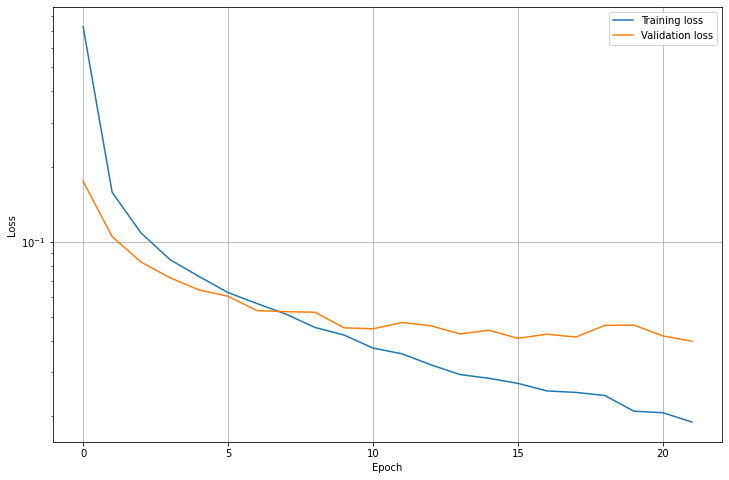

Average traininig  loss in the last 1 epochs: 0.0190
Average validation loss in the last 1 epochs: 0.0400


In [ ]:
kf.view('best')

In [ ]:
ta = np.mean([evaluate_net(e, test_dataset)[1] for e in kf.evolvers])
print(f'average test accuracy = {ta}')

evaluate_net(kf.evolvers[0],test_dataset)

average test accuracy = 0.98742


(     0     1     2     3    4    5    6     7    8    9
 0  971     0     2     0    0    0    3     1    3    0
 1    0  1129     2     0    0    0    3     1    0    0
 2    2     0  1021     0    1    0    0     6    2    0
 3    0     0     3  1003    0    3    0     0    1    0
 4    0     0     0     0  972    0    4     0    1    5
 5    0     1     0     7    0  879    4     0    1    0
 6    3     3     0     0    2    1  946     0    3    0
 7    1     2     2     1    0    0    0  1020    1    1
 8    2     0     4     2    0    1    0     3  957    5
 9    0     2     2     2    9    3    0     6    1  984,
 0.9882)

Losses and accuracies are written as average, best (according to the val loss) over the 5 folds 

Classifier 6 -> 10

* Frozen encoder
  * train loss: 0.3417, 0.3447
  * val loss: 0.3237, 0.3062
  * test accuracy: 0.9126, 0.9120
  * The net moslty confuses 9 and 7, 8 and 3, 8 and 5, 3 and 5
  * 100 epochs of fine-tuning

* Free out layer for the encoder
  * train loss: 0.2108, 0.2121
  * val loss: 0.1912, 0.1830
  * test accuracy: 0.9452, 0.9445
  * The net moslty confuses 9 and 7, 8 and 3, 8 and 5, 3 and 5
  * 80 epochs of fine tuning

* Free linear layers for the encoder
  * train loss: 0.0309, 0.0389
  * val loss: 0.0466, 0.0445
  * test accuracy: 0.9862, 0.9878
  * The net moslty confuses 9 and 4, 2 and 7
  * 16 epochs of fine tuning

* Free last conv layer for the encoder
  * train loss: 0.0206, 0.0190
  * val loss: 0.0427, 0.0400
  * test accuracy: 0.9874, 0.9882 
  * The net moslty confuses 9 and 4, 3 and 5
  * 21 epochs of fine tuning


In [ ]:
enc = Encoder_d(**encoder_params)
enc.load_state_dict(torch.load('fine-tuning/enc.pth'))

Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 6]


<All keys matched successfully>

In [ ]:
test_dataset.transform = sup_transform

df = get_encoded_data(enc, test_dataset)

tsne = TSNE(n_components=2)
raw_data = df.values[:,:-1]
reduced_data = tsne.fit_transform(raw_data)

reduced_df = [{**{f'latent var {i}': reduced_data[j,i] for i in range(reduced_data.shape[1])}, 'label': df.label[j]} for j in range(reduced_data.shape[0])]
reduced_df = pd.DataFrame(reduced_df)

plot_slice_interactive(reduced_df)

interactive(children=(IntSlider(value=0, description='idx1', max=1), IntSlider(value=0, description='idx2', ma…

# GAN

In [37]:
class GAN():
  '''
  Base structure for generative adversarial networks:

  Args:
    generator
    discriminator

    optimizer_type: default optim.Adam
    optimizer_g_params: dictionary of arguments for the optimizer of the generator
    optimizer_d_params: dictionary of arguments for the optimizer of the discriminator

    train_dataset
    val_dataset
    train_batch_size: int, default 256
    val_batch_size: int, default 512

    update_g_every: int, default 1: number of batches every which to update the generator
    update_d_every: int, default 1: number of batches every which to update the discriminator

    loss_function
    fake_loss_weight: float, default 1: the loss of the discriminator is computed as
      (loss_on_real_data + fake_loss_weight*loss_on_fake_data)/(1 + fake_loss_weight)
      For example in case of multi class classification it is better to use fake_loss_weight = number_of_fake_classes/number_of real_classes.
      Usually number_of_fake classes = 1 since every fake image is considered simply fake, without further distinctions.

    
    To inherit from this class it usually sufficient to redefine just the functions
      generate_batch
      auto_sync

  '''
  def __init__(self, generator, discriminator, optimizer_type=optim.Adam, optimizer_g_params=None, optimizer_d_params=None,
               train_dataset=None, val_dataset=None, train_batch_size=256, val_batch_size=512,
               update_g_every=1, update_d_every=1, loss_function=nn.BCELoss(), fake_loss_weight=1):
    self.generator = generator
    self.discriminator = discriminator

    self.optimizer_g = optimizer_type(self.generator.parameters(), **optimizer_g_params)
    self.optimizer_d = optimizer_type(self.discriminator.parameters(), **optimizer_d_params)

    self.update_g_every = update_g_every
    self.update_d_every = update_d_every

    self.loss_function = loss_function

    self.train_dataset = train_dataset
    self.train_dataloader = DataLoader(self.train_dataset, batch_size=train_batch_size,shuffle=True, num_workers=0)

    self.val_dataset = val_dataset
    self.val_dataloader = DataLoader(self.val_dataset, batch_size=val_batch_size,shuffle=False, num_workers=0)

    if isinstance(self.loss_function,nn.CrossEntropyLoss):
      self.label_shape = []
      self.label_type = 'long'
    else:
      self.label_shape = [1]
      self.label_type = 'float'

    self.fake_loss_weight = fake_loss_weight

    self.device = 'cpu'
    self.batches_done = 0

    # lists o [batch_num, loss]
    self.g_log = np.array([])
    self.d_log = np.array([])

    self.g_val_log = np.array([])
    self.d_val_log = np.array([])

  def to(self, device):
    self.generator.to(device)
    self.discriminator.to(device)
    self.device = 'cuda'

  def cpu(self):
    self.generator.cpu()
    self.discriminator.cpu()
    self.device = 'cpu'

  def train(self):
    self.generator.train()
    self.discriminator.train()

  def eval(self):
    self.generator.eval()
    self.discriminator.eval()
  

  def generate_batch(self, labels):
    '''
    Provided real 'labels'
    generates a batch of data:

    Args:
      labels
    Returns:
      real_labels, fake_labels, generated_images
    '''
    batch_size = labels.size()[0]
    real_labels = torch.ones([batch_size] + self.label_shape).float()
    fake_labels = torch.zeros([batch_size] + self.label_shape).float()
    if self.label_type == 'long':
      real_labels = real_labels.long()
      fake_labels = fake_labels.long()

    z = torch.tensor(np.random.normal(0,1, (batch_size, self.generator.shapes[0])), requires_grad=False).float()

    if self.device == 'cuda':
      z = z.to(device)
      real_labels = real_labels.to(device)
      fake_labels = fake_labels.to(device)

    return real_labels, fake_labels, self.generator(z)


  def epoch(self, mode='train'):
    '''
    Performs an epoch of training or validation

    Args:
      mode: 'train' or 'val'
    '''
    if mode == 'train':
      self.train()
    else:
      self.eval()
      self.g_val_log = np.vstack([*self.g_val_log, [self.batches_done, 0.]])
      self.d_val_log = np.vstack([*self.d_val_log, [self.batches_done, 0.]])

    dl = self.train_dataloader if mode == 'train' else self.val_dataloader

    for real_img_batch, labels in dl:
      if self.device == 'cuda':
        real_img_batch = real_img_batch.to(device)

      # generate fake images
      real_labels, fake_labels, fake_img_batch = self.generate_batch(labels)
      
      # update the generator
      if self.batches_done % self.update_g_every == 0 or mode == 'val':
        if mode == 'train':
          self.optimizer_g.zero_grad()

        fake_validity = self.discriminator(fake_img_batch)
        # print(fake_validity)

        g_loss = self.loss_function(fake_validity, real_labels) # the objective of g is to convince d its images are real
        if mode == 'train':
          g_loss.backward()
          self.optimizer_g.step()

        if mode == 'train':
          self.g_log = np.vstack([*self.g_log, [self.batches_done, g_loss.detach().cpu().numpy()]])
        else:
          self.g_val_log[-1,1] += g_loss.detach().cpu().numpy()*labels.size()[0]
        

      # update the discriminator
      if self.batches_done % self.update_d_every == 0 or mode == 'val':
        if mode == 'train':
          self.optimizer_d.zero_grad()

        fake_validity = self.discriminator(fake_img_batch.detach())
        d_loss_fake = self.loss_function(fake_validity, fake_labels)

        real_validity = self.discriminator(real_img_batch)
        d_loss_real = self.loss_function(real_validity, real_labels)

        d_loss = (d_loss_fake*self.fake_loss_weight + d_loss_real)/(1 + self.fake_loss_weight)
        if mode == 'train':
          d_loss.backward()
          self.optimizer_d.step()

        if mode == 'train':
          self.d_log = np.vstack([*self.d_log, [self.batches_done, d_loss.detach().cpu().numpy()]])
        else:
          self.d_val_log[-1,1] += d_loss.detach().cpu().numpy()*labels.size()[0]

      if mode == 'train':
        self.batches_done += 1

    if mode == 'val':
      self.d_val_log[-1,1:] /= len(self.val_dataset)
      self.g_val_log[-1,1:] /= len(self.val_dataset)
      

  def evolve(self, num_epochs, verbose=False):
    '''
    Evolves the GAN for 'num_epochs'
    '''
    for i in tqdm(range(num_epochs)):
      self.epoch('train')
      
      with torch.no_grad():
        self.epoch('val')

      if verbose:
        print('g train: ', self.g_log[-1])
        print('g val: ', self.g_val_log[-1])
        print('d train: ', self.d_log[-1])
        print('d val: ', self.d_val_log[-1], '\n')

      self.auto_sync(verbose)

  def auto_sync(self,verbose):
    '''
    In this base version does nothing
    '''
    return


  def plot_losses(self):
    '''
    Plots the behavior of the loss for generator and discriminator
    '''
    plt.figure(figsize=(12,8))
    
    plt.plot(self.g_log[:,0], self.g_log[:,1], color='blue', label='g train loss', alpha=0.3)
    plt.plot(self.g_val_log[:,0], self.g_val_log[:,1], color='cyan', label='g val loss')
    
    plt.plot(self.d_log[:,0], self.d_log[:,1], color='red', label='d train loss', alpha=0.3)    
    plt.plot(self.d_val_log[:,0], self.d_val_log[:,1], color='orange', label='d val loss')
    plt.xlabel('batches done')
    plt.ylabel('loss')
    plt.legend()


In [ ]:
# testing

generator = Decoder(Ni=6,Nhs=[57], channels=[17,12,6], kernel_sizes=[3,2,2], strides=[3,1,1], paddings=[1,0,1],
                    o_act=nn.Sigmoid())

# generator.load_state_dict(torch.load('tmp/best1/dec.pth'))

discriminator = Encoder(channels=[8,16,32],kernel_sizes=[3,3,3], strides=[2,2,2], paddings=[0,0,0], Nhs=[64,8], No=1, o_act=nn.Sigmoid())

train_dataset.transform = sup_transform
val_dataset.transform = sup_transform
test_dataset.transform = sup_transform

gan = GAN(generator,discriminator,
          optimizer_d_params={'lr': 1e-4},
          optimizer_g_params={'lr': 1e-3},
          train_dataset=train_dataset, val_dataset=val_dataset, train_batch_size=64,
          update_g_every=1, loss_function=nn.BCELoss())

Automatically setting o_paddings = [0, 0, 0]
Decoder initialized
Shape flow:  [6, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]
Encoder initialized
Shape flow:  [(1, 28, 28), (8, 13, 13), (16, 6, 6), (32, 2, 2), 128, 64, 8, 1]


In [ ]:
gan.update_d_every = 10

gan.to(device)
try:
  gan.evolve(10,verbose=True)
except KeyboardInterrupt:
  gan.cpu()
gan.cpu()

gan.plot_losses()

In [ ]:
interactive_generation(generator,add_sigmoid=False)

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='i0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

This is pretty rubbish

## Wasserstein GAN

In [38]:
class WLoss():
  '''
  Wasserstein Loss
  '''
  def __init__(self):
    return

  def __call__(self, input, target):
    '''
    target is supposed to have values +1 or -1
    '''
    return -torch.mean(input*target)

class WGAN(GAN):
  '''
  Wasserstein GAN

  Args:
    clip_value: float, default 1: weight of the discriminator are clipped in [-clip_value, clip_value] after every update

    *args, **kwargs: arguments for the parent class
  '''
  def __init__(self, *args, clip_value=1, **kwargs):
    super().__init__(*args, **kwargs)

    self.clip_value = clip_value

  def generate_batch(self, labels):
    # clip weights of the discriminator
    for p in self.discriminator.parameters():
      p.data.clamp_(-self.clip_value, self.clip_value)

    batch_size = labels.size()[0]
    real_labels = torch.ones([batch_size] + self.label_shape).float()
    fake_labels = torch.ones([batch_size] + self.label_shape).float()*(-1)
    if self.label_type == 'long':
      real_labels = real_labels.long()
      fake_labels = fake_labels.long()

    z = torch.tensor(np.random.normal(0,1, (batch_size, self.generator.shapes[0])), requires_grad=False).float()

    if self.device == 'cuda':
      z = z.to(device)
      real_labels = real_labels.to(device)
      fake_labels = fake_labels.to(device)

    return real_labels, fake_labels, self.generator(z)

In [ ]:
# testing

generator = Decoder(Ni=100,Nhs=[57], channels=[17,12,6], kernel_sizes=[3,2,2], strides=[3,1,1], paddings=[1,0,1],
                    o_act=nn.Sigmoid())

discriminator = Encoder(channels=[6,12,17],kernel_sizes=[2,2,3], strides=[1,1,3], paddings=[1,0,1], Nhs=[57], No=1, o_act=nn.Identity())

train_dataset.transform = sup_transform
val_dataset.transform = sup_transform
test_dataset.transform = sup_transform

gan = WGAN(generator,discriminator, optimizer_type=optim.Adam,
          optimizer_d_params={'lr': 1e-3, 'weight_decay': 1e-5},
          optimizer_g_params={'lr': 1e-3},
          train_dataset=train_dataset, val_dataset=val_dataset, train_batch_size=64,
          update_g_every=1, loss_function=WLoss(), clip_value=0.1)

Decoder initialized
Shape flow:  [100, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]
Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 1]


In [ ]:
gan.update_g_every = 5

gan.to(device)
try:
  gan.evolve(50,verbose=True)
except KeyboardInterrupt:
  gan.cpu()
gan.cpu()

gan.plot_losses()

In [ ]:
interactive_generation(generator,add_sigmoid=False)

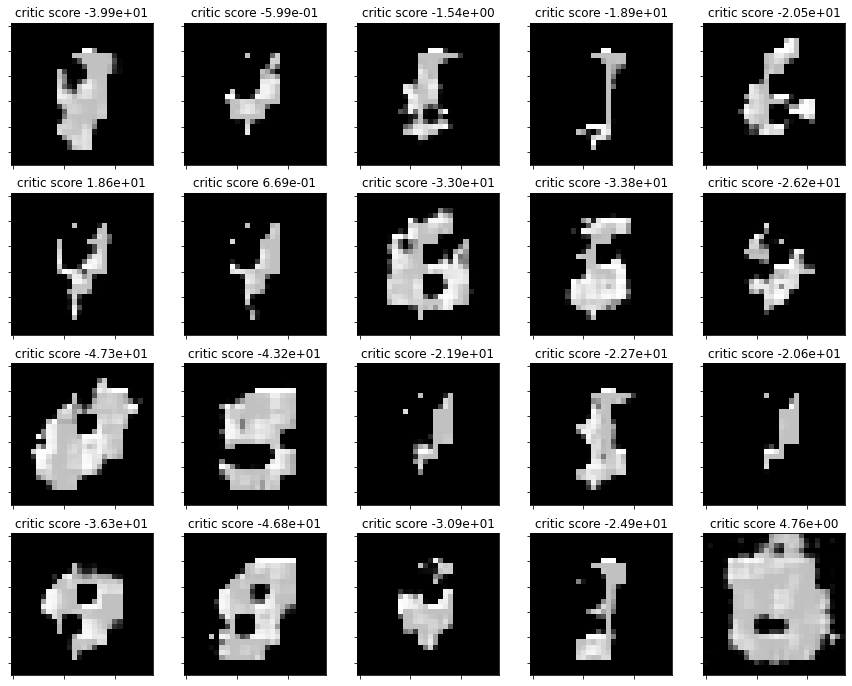

In [ ]:
figsize_unit = 3
nrows = 4
ncols = 5

fig, axs = plt.subplots(nrows,ncols, figsize=(ncols*figsize_unit, nrows*figsize_unit))

for j in range(nrows):
  gen_batch = gan.generate_batch(torch.tensor([0,1,2,3,4,5,6,7,8,9]).long())[-1]
  discriminator_opinion = (gan.discriminator(gen_batch).detach().cpu().squeeze().numpy())

  # print(discriminator_opinion)
  for i in range(ncols):
    axs[j,i].imshow(gen_batch[i].detach().squeeze().cpu().numpy(), cmap='gist_gray', vmin=0, vmax=1)
    axs[j,i].tick_params(axis='both', labelbottom=False, labelleft=False)
    axs[j,i].set_title(f'critic score {discriminator_opinion[i] :.2e}')

In [ ]:
img = test_dataset[0][0]

score = discriminator(img.unsqueeze(0)).detach().squeeze().cpu().numpy()

plt.figure(figsize=(12,8))
plt.imshow(img.squeeze().cpu().detach().numpy(), cmap='gist_gray')
plt.title(f'{score = :.2e}')

This one as well is pretty rubbish

## ACGAN

In [39]:
class ACGAN_external_embedding(GAN):
  '''
  Requires the Decoder to not be a Decoder_e class
  The input of the generator is the embedding of real label plus some random noise
  The output of the discriminator are 11 classes: 0,1,2,3,4,5,6,7,8,9,fake

  Args:
    noise_amount: standard deviation of the gaussian noise that is summed to the embedding before being passed to the generator

    *args, **kwargs: arguments of the parent class
  '''
  def __init__(self, *args, noise_amount=1, **kwargs):
    super().__init__(*args, **kwargs)

    if not isinstance(self.loss_function, nn.CrossEntropyLoss):
      print(self.loss_function, ' is not adeguate for the ACGAN: using CrossEntropyLoss')
      self.loss_function = nn.CrossEntropyLoss()
      self.label_shape = []
      self.label_type = 'long'

    self.noise_amount = noise_amount

    self.embedding = nn.Embedding(10, self.generator.shapes[0])

  def generate_batch(self, labels):
    batch_size = labels.size()[0]
    real_labels = labels
    fake_labels = torch.ones([batch_size]).long()*10

    z = torch.tensor(np.random.normal(0,self.noise_amount, (batch_size, self.generator.shapes[0])), requires_grad=False).float()
    label_embeddings = self.embedding(labels)

    z += label_embeddings

    if self.device == 'cuda':
      z = z.to(device)
      real_labels = real_labels.to(device)
      fake_labels = fake_labels.to(device)

    return real_labels, fake_labels, self.generator(z)


class Decoder_e(Decoder):
  '''
  Decoder with an internal embedding layer of size the number of input neurons

  Args:
    *args, **kwargs: arguments of the base Decoder

  The forward method takes as input an int for the class id and the noise to be summed to the embedding
  '''
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.embedding = nn.Embedding(10, self.shapes[0])
    self.noise_neurons = self.shapes[0]

  def forward(self, x, noise):
    # embedding and noise
    x = self.embedding(x) + noise

    # apply linear layers
    x = self.lin_layers(x)
    # unflatten
    x = self.unflatten(x)
    # apply convolutional layers
    x = self.conv_layers(x)
    # output layer
    x = self.o_act(x)
    return x


class ACGAN(GAN):
  '''
  Requires the decoder to be a Decoder_e or Decoder_c class
  The output of the discriminator are 11 classes: 0,1,2,3,4,5,6,7,8,9,fake

  Args:
    noise_amount: standard deviation of the gaussian noise that is summed to the embedding before being passed to the generator

    *args, **kwargs: arguments of the parent class
  '''
  def __init__(self, *args, noise_amount=1, **kwargs):
    super().__init__(*args, **kwargs)

    if not isinstance(self.loss_function, nn.CrossEntropyLoss):
      print(self.loss_function, ' is not adeguate for the ACGAN: using CrossEntropyLoss')
      self.loss_function = nn.CrossEntropyLoss()
      self.label_shape = []
      self.label_type = 'long'

    self.noise_amount = noise_amount

  def generate_batch(self, labels):
    batch_size = labels.size()[0]
    real_labels = labels
    fake_labels = torch.ones([batch_size]).long()*10

    z = torch.tensor(np.random.normal(0,self.noise_amount, (batch_size, self.generator.noise_neurons)), requires_grad=False).float()

    if self.device == 'cuda':
      z = z.to(device)
      real_labels = real_labels.to(device)
      fake_labels = fake_labels.to(device)

    return real_labels, fake_labels, self.generator(real_labels, z)


class Decoder_c(Decoder):
  '''
  Instead of adding noise to the neurons it reserves part of the input neurons to noise and the others to the embedding

  Args:
    noise_neurons: int, default 2: number of neurons asigned to noise. input_neurons - noise_neurons will be assigned to the embedding
      Must be noise_neurons < input_neurons

    *args, **kwargs: arguments of the base Decoder

  The forward method takes as input an int for the class id and the noise to be summed to the embedding
  '''
  def __init__(self, *args, noise_neurons=2, **kwargs):
    super().__init__(*args, **kwargs)

    self.noise_neurons = noise_neurons
    self.embedding = nn.Embedding(10, self.shapes[0] - self.noise_neurons)

  def forward(self, x, noise):
    # embedding and noise
    x = torch.cat([self.embedding(x), noise], dim=1)

    # apply linear layers
    x = self.lin_layers(x)
    # unflatten
    x = self.unflatten(x)
    # apply convolutional layers
    x = self.conv_layers(x)
    # output layer
    x = self.o_act(x)
    return x

In [ ]:
# testing

generator = Decoder_e(Ni=10,Nhs=[57], channels=[17,12,6], kernel_sizes=[3,2,2], strides=[3,1,1], paddings=[1,0,1],
                    o_act=nn.Sigmoid())

discriminator = Encoder(channels=[6,12,17],kernel_sizes=[2,2,3], strides=[1,1,3], paddings=[1,0,1], Nhs=[57], No=11, o_act=nn.Identity())

train_dataset.transform = sup_transform
val_dataset.transform = sup_transform
test_dataset.transform = sup_transform

gan = ACGAN(generator,discriminator,
          optimizer_d_params={'lr': 1e-3},
          optimizer_g_params={'lr': 1e-3},
          train_dataset=train_dataset, val_dataset=val_dataset, train_batch_size=256,
          update_g_every=1, loss_function=nn.CrossEntropyLoss(),
          fake_loss_weight=0.1)

Automatically setting o_paddings = [0, 0, 0]
Decoder initialized
Shape flow:  [10, 57, 1700, (17, 10, 10), (12, 28, 28), (6, 29, 29), (1, 28, 28)]
Encoder initialized
Shape flow:  [(1, 28, 28), (6, 29, 29), (12, 28, 28), (17, 10, 10), 1700, 57, 11]


In [ ]:
gan.update_d_every = 3

gan.to(device)
try:
  gan.evolve(10,verbose=True)
except KeyboardInterrupt:
  gan.cpu()
gan.cpu()

gan.plot_losses()

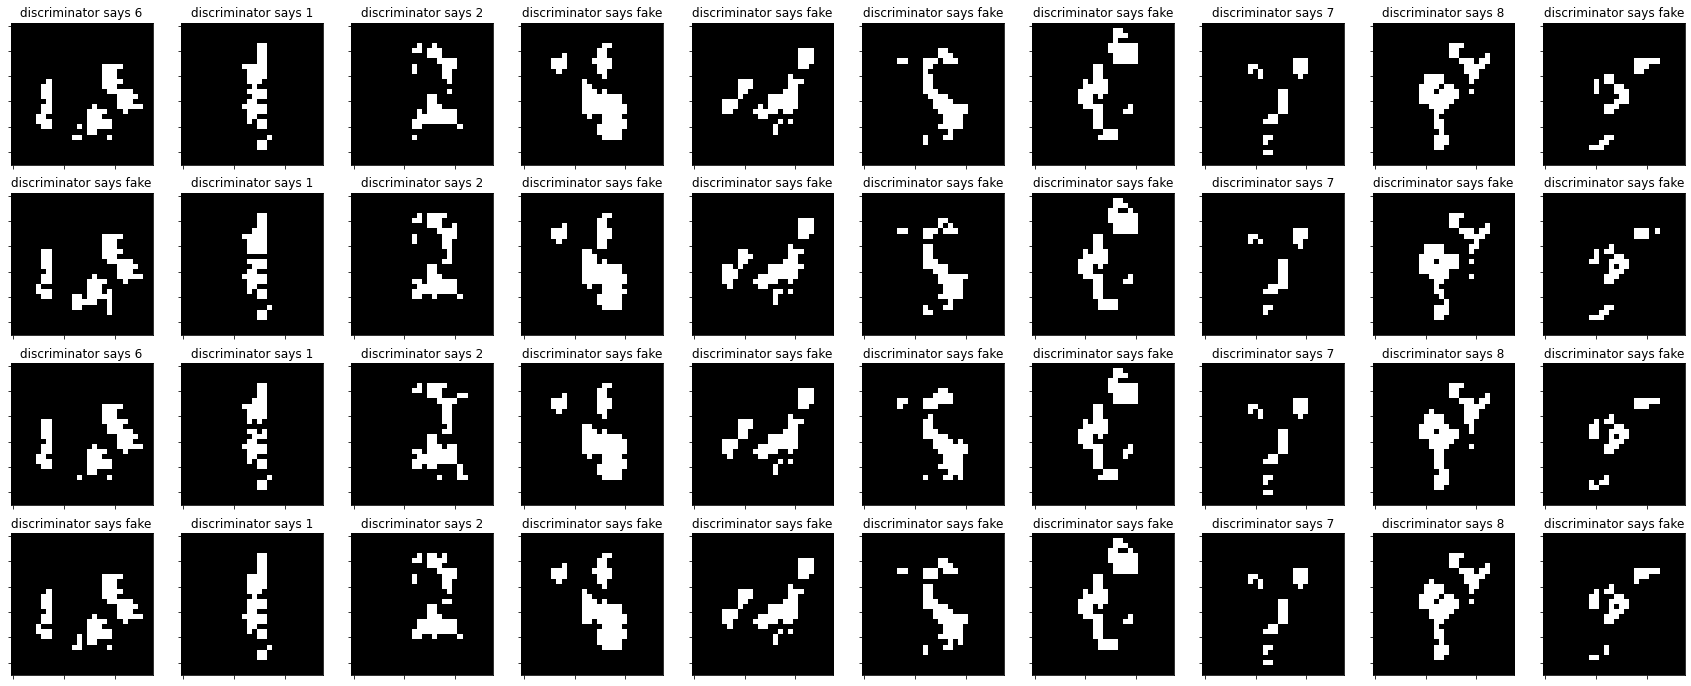

In [ ]:
# gan.noise_amount = 0.1

figsize_unit = 3
nrows = 4

fig, axs = plt.subplots(nrows,10, figsize=(10*figsize_unit, nrows*figsize_unit))

for j in range(nrows):
  with torch.no_grad():
    gen_batch = gan.generate_batch(torch.tensor([0,1,2,3,4,5,6,7,8,9]).long())[-1]
    discriminator_opinion = list(torch.argmax(gan.discriminator(gen_batch), dim=1).detach().cpu().numpy())
  for i,n in enumerate(discriminator_opinion):
    if n > 9:
      discriminator_opinion[i] = 'fake'

  # print(discriminator_opinion)
  for i in range(10):
    axs[j,i].imshow(gen_batch[i].detach().squeeze().cpu().numpy(), cmap='gist_gray', vmin=0, vmax=1)
    axs[j,i].tick_params(axis='both', labelbottom=False, labelleft=False)
    axs[j,i].set_title(f'discriminator says {discriminator_opinion[i]}')

Text(0, 0.5, 'probability')

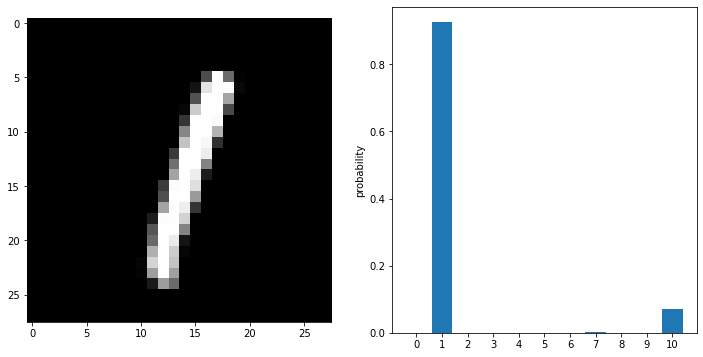

In [ ]:
img = test_dataset[5][0]
# img = pe.create_image()

y = torch.softmax(gan.discriminator(img.unsqueeze(0)), dim=1)

y = y.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img.squeeze().cpu().numpy(), cmap='gist_gray', vmax=1, vmin=0)
ax[1].bar(np.arange(11), y)
ax[1].set_xticks(np.arange(11))
ax[1].set_ylabel('probability')

In [ ]:
gan.generator.embedding(torch.tensor([0,1,2,3,4,5,6,7,8,9]).long())

### Auto synchronization

In [40]:
class ACGAN_auto_sync(ACGAN):
  '''
  Automatically sichronizes the learning of discriminator and generator in order to have their loss functions as similar as possible

  Args:
    tolerance: float, default 0.1
    bias: int, default 0

      At the end of every epoch it is computed
        d = (generator.val_loss - discriminator.val_loss)//tolerance

      Then
        update_d_every += d - bias
        update_g_every -= d

        both are then clipped to be at least 1

    *args, **kwargs: arguments of the parent class
  '''
  def __init__(self, *args, tolerance=0.1, bias=0, **kwargs):
    super().__init__(*args, **kwargs)

    self.tolerance = tolerance
    self.bias = bias

    self.update_every_log = [(self.update_g_every, self.update_d_every)]

  def auto_sync(self, verbose=False):
    val_loss_diff = self.g_val_log[-1,-1] - self.d_val_log[-1,-1]

    self.update_d_every = max(self.update_d_every + val_loss_diff//self.tolerance - self.bias, 1)
    self.update_g_every = max(self.update_g_every - val_loss_diff//self.tolerance, 1)

    self.update_every_log.append((self.update_g_every, self.update_d_every))
    if verbose:
      print(f'updating g and d respectively every {self.update_every_log[-1]} batches')

In [ ]:
# testing

generator = Decoder_e(Ni=10,Nhs=[57], channels=[17,12,6], kernel_sizes=[3,2,2], strides=[3,1,1], paddings=[1,0,1],
                    o_act=nn.Sigmoid())

discriminator = Encoder(channels=[6,12,17],kernel_sizes=[2,2,3], strides=[1,1,3], paddings=[1,0,1], Nhs=[57], No=11, o_act=nn.Identity())

train_dataset.transform = sup_transform
val_dataset.transform = sup_transform
test_dataset.transform = sup_transform

gan = ACGAN_auto_sync(generator,discriminator,optimizer_type=optim.Adam,
          optimizer_d_params={'lr': 1e-3, 'weight_decay': 1e-6},
          optimizer_g_params={'lr': 1e-3, 'weight_decay': 1e-6},
          train_dataset=train_dataset, val_dataset=val_dataset, train_batch_size=128,
          loss_function=nn.CrossEntropyLoss(),
          fake_loss_weight=0.1, noise_amount=1,
          tolerance=0.1, bias=1)

In [ ]:
# gan.update_d_every = 3
# gan.tolerance = 0.1

gan.to(device)
try:
  gan.evolve(10,verbose=True)
except KeyboardInterrupt:
  gan.cpu()
gan.cpu()

gan.plot_losses()

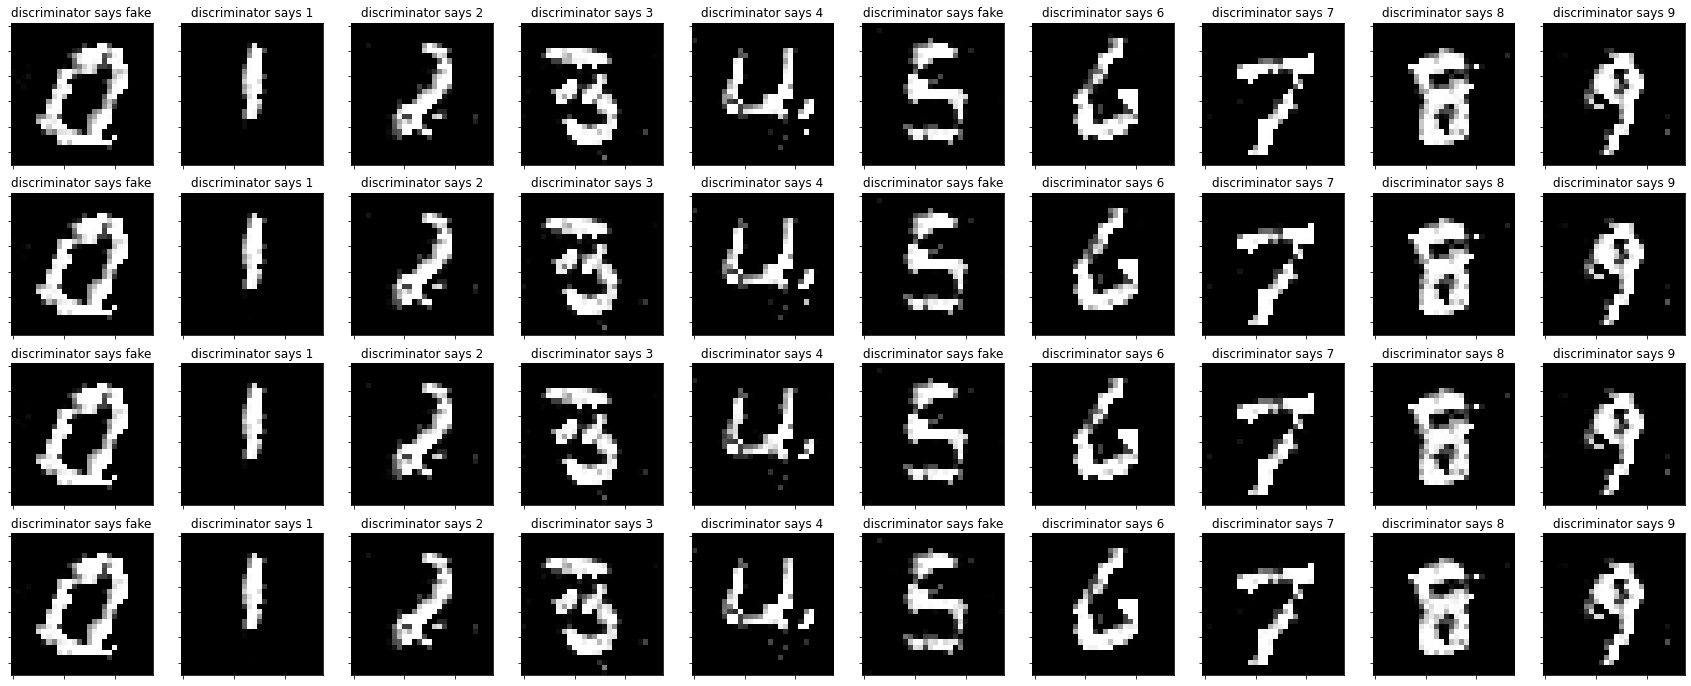

In [56]:
figsize_unit = 3
nrows = 4

fig, axs = plt.subplots(nrows,10, figsize=(10*figsize_unit, nrows*figsize_unit))

for j in range(nrows):
  with torch.no_grad():
    gen_batch = gan.generate_batch(torch.tensor([0,1,2,3,4,5,6,7,8,9]).long())[-1]
    discriminator_opinion = list(torch.argmax(gan.discriminator(gen_batch), dim=1).detach().cpu().numpy())
  for i,n in enumerate(discriminator_opinion):
    if n > 9:
      discriminator_opinion[i] = 'fake'

  # print(discriminator_opinion)
  for i in range(10):
    axs[j,i].imshow(gen_batch[i].detach().squeeze().cpu().numpy(), cmap='gist_gray', vmin=0, vmax=1)
    axs[j,i].tick_params(axis='both', labelbottom=False, labelleft=False)
    axs[j,i].set_title(f'discriminator says {discriminator_opinion[i]}')

In [48]:
torch.save(discriminator.state_dict(), 'ACGAN/discriminator.pth')
torch.save(generator.state_dict(), 'ACGAN/generator.pth')

In [ ]:
discriminator.load_state_dict(torch.load('ACGAN/discriminator.pth'))
generator.load_state_dict(torch.load('ACGAN/generator.pth'))